<h1><center>DS Capstone Project - Barcelona vs Paris - Let the battle begin.</center></h1><h3><center>Barcelona vs Paris - How (dis)similar are they?</center></h3>

<h3>1. Problem and discussion of the background.</h3>

Barcelona and Paris are two of my most favourite cities in Europe. But why is it that I like these cities the most? Are they similar or very dissimilar. Both cities have different backgrounds, but what makes them so popular. Let's find out if we can use data to solve my problem and to find out which city should be chosen for the next visit.

<h3>2. How will data be used to solve the problem. </h3>

Now we have chosen to use data to find out the (dis)similarities between the two cities, we need to decide which/what data to use. Let's use data from Wikipedia and FourSquare and find out if they can help us to find the answer!
To specify our quest a little bit more we will look for venues and more specifically the number of Vietnamese, Chinese, and Japanese restaurants in both cities as well as list down the 10 most common venues in both cities Neighbourhood wise. I have chosen these types of cuisines as I have an South-East Asian background. Foursquare is a perfect provider to supply us this data.
Wikipedia will be used for getting a start on geospatial information on the districts of Barcelona and arrondissements of Paris.
The outcome of the study will be used to determine to which city the next visit will be organized.

<h3>3. Let the battle begin. </h3>

First I'm installing all clients and importing all libraries which are required to perform the analysis.
I will also predefine my FourSquare credentials, which will be used when retrieving the data from FourSquare.
Finally I will define the functions which will be used during the analysis for both datasets.

In [1]:
! pip install geopy

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Below the FourSquare credentials which will be used and the variables which will be send within the URL requests.

In [3]:
## Foursquare ID
CLIENT_ID = 'NDGX4RBYCYKMWHJNX2MALLNW4ETTWAXUP3D54BN3N5MEGBVJ' # your Foursquare ID
CLIENT_SECRET = 'LUXBWPXTLFIEYSOGH4JI5TM4MBWS5010VBHZ2J243HQJMC10' # your Foursquare Secret
VERSION = '20200630' # Foursquare API version

#Fourshare Variables
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

venue_category_1 = '4bf58dd8d48988d14a941735' # Vietnamese restaurant 
venue_category_2 = '4bf58dd8d48988d145941735' # Chinese restaurant
venue_category_3 = '4bf58dd8d48988d111941735' # Japanese restaurant

category_list = ['Vietnamese Restaurant' , 'Chinese Restaurant', 'Japanese Restaurant']

Below the code to the hierarchical category list from Foursquare. As mentioned I will also specifically look at the Vietnamese, Japanese and Chinese Restaurants. However Japanese and Chinese restaurants have the ability to further specify the type of cuisine they serve. Therefore it's needed to have a complete list of all cuisines and their main cuisine.
FourSquare provides the hierarchical category through a JSON-file which can be requested through an URL. The JSON-file contains the hierarchical category list through a nested way. To flatten the nested JSON-file the file is flattened with the Pandas library.

In [4]:
#Retrieve the hierarchical category list from FourSquare
venue_categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION)

#venue_categories_url
#!wget -q -O 'venue_categories_hierarchy.json' "https://api.foursquare.com/v2/venues/categories?client_id=NDGX4RBYCYKMWHJNX2MALLNW4ETTWAXUP3D54BN3N5MEGBVJ&client_secret=LUXBWPXTLFIEYSOGH4JI5TM4MBWS5010VBHZ2J243HQJMC10&v=20180605"
#print('Data downloaded!')

venue_results = requests.get(venue_categories_url).json()["response"]['categories'][3]

# The main category is extracted from the JSON-file.
venue_results_main = pd.json_normalize(data=venue_results)
venue_results_main = venue_results_main.rename(columns={'name': 'MainCategoryName'})
venue_results_main = venue_results_main.drop(columns=['categories', 'pluralName', 'shortName', 'icon.prefix', 'icon.suffix'])

# The 1st level below the main category is extracted from the JSON-file and superfluous columns are dropped.
venue_results_1 = pd.json_normalize(data=venue_results, record_path=['categories'], meta=['id'], record_prefix='l1_')
venue_results_1 = venue_results_1.drop(columns=['l1_categories','l1_pluralName', 'l1_shortName', 'l1_icon.prefix', 'l1_icon.suffix'])

# The 2nd level below the main category is extracted from the JSON-file and superfluous columns are dropped. Columns which are also in the previous dataframe will be renamed.
venue_results_2 = pd.json_normalize(data=venue_results, record_path=['categories','categories'], meta=[['name','id']], record_prefix='l2_')
venue_results_2 = venue_results_2.rename(columns={'name.id': 'CategoryId_l1', 'l2_id':'CategoryId_l2', 'l2_name':'CategoryName_l2'})
venue_results_2 = venue_results_2.drop(columns=['l2_categories','l2_pluralName', 'l2_shortName', 'l2_icon.prefix', 'l2_icon.suffix'])

# The 3rd level below the main category is extracted from the JSON-file and superfluous columns are dropped. Columns which are also in the previous dataframe will be renamed.
venue_results_3 = pd.json_normalize(data=venue_results, record_path=['categories','categories','categories'], meta=[['name', 'name','id']], record_prefix='l3_')
venue_results_3 = venue_results_3.rename(columns={'name.name.id': 'CategoryId_l2', 'l3_id':'CategoryId_l3', 'l3_name':'CategoryName_l3'})
venue_results_3 = venue_results_3.drop(columns=['l3_categories','l3_pluralName', 'l3_shortName', 'l3_icon.prefix', 'l3_icon.suffix'])

# The 4th level below the main category is extracted from the JSON-file and superfluous columns are dropped. Columns which are also in the previous dataframe will be renamed. The 4th level is the lowest level to be found.
venue_results_4 = pd.json_normalize(data=venue_results, record_path=['categories','categories','categories','categories'], meta=[['name','name', 'name','id']], record_prefix='l4_')
venue_results_4 = venue_results_4.rename(columns={'name.name.name.id': 'CategoryId_l3', 'l4_id':'CategoryId_l4', 'l4_name':'CategoryName_l4'})
venue_results_4 = venue_results_4.drop(columns=['l4_categories','l4_pluralName', 'l4_shortName', 'l4_icon.prefix', 'l4_icon.suffix'])

#The final hierarchical category list will be constructed, by merging the previous dataframes.
venue_categories = pd.merge(venue_results_main, venue_results_1, how='inner', on='id')
venue_categories = venue_categories.rename(columns={'id': 'MainCategoryId', 'l1_id': 'CategoryId_l1', 'l1_name': 'CategoryName_L1' } )

venue_categories = pd.merge(venue_categories, venue_results_2, how='left', left_on='CategoryId_l1', right_on='CategoryId_l1')
venue_categories = pd.merge(venue_categories, venue_results_3, how='left', left_on='CategoryId_l2', right_on='CategoryId_l2')
venue_categories = pd.merge(venue_categories, venue_results_4, how='left', left_on='CategoryId_l3', right_on='CategoryId_l3')
venue_categories = venue_categories.drop(columns=['MainCategoryId','CategoryId_l1', 'CategoryId_l2', 'CategoryId_l3', 'CategoryId_l4'])

#Categories that have no subcategories will get the category of the higher level. 
venue_categories.CategoryName_l2.fillna(venue_categories.CategoryName_L1, inplace=True)
venue_categories.CategoryName_l3.fillna(venue_categories.CategoryName_l2, inplace=True)
venue_categories.CategoryName_l4.fillna(venue_categories.CategoryName_l3, inplace=True)
venue_categories.head()

MainCategoryName      CategoryName_L1          CategoryName_l2          CategoryName_l3          CategoryName_l4
0             Food    Afghan Restaurant        Afghan Restaurant        Afghan Restaurant        Afghan Restaurant
1             Food   African Restaurant     Ethiopian Restaurant     Ethiopian Restaurant     Ethiopian Restaurant
2             Food   African Restaurant     Mauritian Restaurant     Mauritian Restaurant     Mauritian Restaurant
3             Food  American Restaurant  New American Restaurant  New American Restaurant  New American Restaurant
4             Food  Armenian Restaurant      Armenian Restaurant      Armenian Restaurant      Armenian Restaurant

Below the three functions that will be used to get all venues given the variables. The first function retrieves all venues, whereas the second function only retrieves the venues that match the specified category conditions.
The third function is able to sort the most common venues in descending order.

In [5]:
# Function to get all nearby venues given the geo coordinates of a place.
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [6]:
# Function to get all nearby venues which match the given Category Id's and given the geo coordinates of a place.
def getNearbyVenuesCat(names, latitudes, longitudes, radius=500):
    
    venues_list_cat=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url_cat = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={},{},{}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            venue_category_1,
            venue_category_2,
            venue_category_3)
            
        # make the GET request
        results_cat = requests.get(url_cat).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list_cat.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results_cat])

    nearby_venues_cat = pd.DataFrame([item for venues_list_cat in venues_list_cat for item in venues_list_cat])
    nearby_venues_cat.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues_cat)

In [7]:
#Function to sort the most common venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]





<h3>3.1 Show Barcelona and the boroughs (districts) on the map. </h3>

Barcelona has in total 10 boroughs (called districts) and 75 neighborhoods. To explore, analyze and segment neighborhoods, longitude and latitude of each neighborhood and borough will be added.
The data is stored in a CSV file and its content is retrieved through Wikipedia.

In [8]:
!wget -q -O 'barcelona_districts_geodata.csv'  "https://raw.githubusercontent.com/AQuynhVo/Quynh_Repo/master/DS_Capstone_Project/barcelona_districts_geodata.csv"
print('Data downloaded!')

Data downloaded!


In [9]:
bcn_data = pd.read_csv('barcelona_districts_geodata.csv', sep=';')

bcn_data.head(5)

District                          Neighbourhood   Latitude  Longitude
0  Ciutat Vella                         La Barceloneta  41.379889   2.189361
1  Ciutat Vella                               El Gòtic  41.382778   2.176944
2  Ciutat Vella                               El Raval  41.379722   2.168056
3  Ciutat Vella  Sant Pere, Santa Caterina i la Ribera  41.384608   2.182717
4      Eixample        L'Antiga Esquerra de l'Eixample  41.390000   2.155000

In [10]:
print('The Barcelona dataframe has {} boroughs (Districts) and {} neighbourhoods.'.format(
        len(bcn_data['District'].unique()),
        bcn_data.shape[0]
    )
)

The Barcelona dataframe has 10 boroughs (Districts) and 75 neighbourhoods.


In [11]:
bcn_address = 'Barcelona, ES'

geolocator = Nominatim(user_agent="bcn_explorer")
bcn_location = geolocator.geocode(bcn_address)
bcn_latitude = bcn_location.latitude
bcn_longitude = bcn_location.longitude
print('The geographical coordinate of Barcelona (ES) are {}, {}.'.format(bcn_latitude, bcn_longitude))

The geographical coordinate of Barcelona (ES) are 41.3828939, 2.1774322.


Now we have the geographical coordinates of Barcelona, but also of it's neighbourhoods, let's show them on the map.

In [12]:
# create map of Barcelona using latitude and longitude values
map_barcelona = folium.Map(location=[bcn_latitude, bcn_longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighbourhood in zip(bcn_data['Latitude'], bcn_data['Longitude'], bcn_data['District'], bcn_data['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_barcelona)  
    
    
# display map
map_barcelona

<h3>3.2 Using Foursquare to discover Barcelona Venues. </h3>

As said before we'll use Foursquare to discover the venues in Barcelona. In the first analysis we'll retrieve all venues in Barcelona with the function we've defined earlier.
In the second analysis we'll only retrieve the venues that match our condition of Chinese, Japanese and Vietnamese cuisine.

<h4>3.2.1 Using Foursquare to discover Barcelona Venues from all kinds of categories for each Neighbourhood</h4>

In [13]:
barcelona_venues = getNearbyVenues(names=bcn_data['Neighbourhood'],
                                   latitudes=bcn_data['Latitude'],
                                   longitudes=bcn_data['Longitude']
                                  )

In [14]:
print(barcelona_venues.shape)
barcelona_venues.head(5)

(2936, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude                    Venue  Venue Latitude  Venue Longitude    Venue Category
0  La Barceloneta              41.379889                2.189361      Baluard Barceloneta       41.380047         2.189250            Bakery
1  La Barceloneta              41.379889                2.189361                      BRO       41.380214         2.189007      Burger Joint
2  La Barceloneta              41.379889                2.189361           La Cova Fumada       41.379254         2.189254  Tapas Restaurant
3  La Barceloneta              41.379889                2.189361  Plaça de la Barceloneta       41.379739         2.188135             Plaza
4  La Barceloneta              41.379889                2.189361             acqua&farina       41.381023         2.190152       Pizza Place

In [15]:
#Let's check how many venues were returned for each neighborhood
barcelona_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  Venue Latitude  Venue Longitude  Venue Category
Neighborhood                                                                                                                                       
Baró de Viver                                                     4                       4      4               4                4               4
Bon Pastor                                                        8                       8      8               8                8               8
Can Baró                                                         20                      20     20              20               20              20
Can Peguera                                                      31                      31     31              31               31              31
Canyelles                                                         8                       8      8               8                8               8
Ciutat Meridiana                                                  8                       8      8               8                8               8
Diagonal Mar i el Front Marítim del Poblenou                     84                      84     84              84               84              84
Dreta de l'Eixample                                              96                      96     96              96               96              96
El Baix Guinardó                                                 38                      38     38              38               38              38
El Besòs i el Maresme                                             9                       9      9               9                9               9
El Camp de l'Arpa del Clot                                       84                      84     84              84               84              84
El Carmel                                                        17                      17     17              17               17              17
El Congrés i els Indians                                         27                      27     27              27               27              27
El Guinardó                                                      15                      15     15              15               15              15
El Gòtic                                                        100                     100    100             100              100             100
El Poble-sec                                                     89                      89     89              89               89              89
El Putget i Farró                                                28                      28     28              28               28              28
El Raval                                                        100                     100    100             100              100             100
El Turó de la Peira                                              28                      28     28              28               28              28
Fort Pienc                                                       25                      25     25              25               25              25
Horta                                                            48                      48     48              48               48              48
Hostafrancs                                                      57                      57     57              57               57              57
L'Antiga Esquerra de l'Eixample                                 100                     100    100             100              100             100
La Barceloneta                                                   91                      91     91              91               91              91
La Bordeta                                                       42                      42     42              42               42              42
La Guineueta                                      

In [16]:
# Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories in Barcelona.'.format(len(barcelona_venues['Venue Category'].unique())))

There are 274 uniques categories in Barcelona.


In [17]:
#Analyze Each Neighborhood of Barcelona
# one hot encoding
barcelona_onehot = pd.get_dummies(barcelona_venues[['Venue Category']], prefix="", prefix_sep="")

#Somehow there's this column Neighborhood in the barcelona_onehot dataframe
barcelona_onehot = barcelona_onehot.drop(columns=['Neighborhood'])

# add neighborhood column back to dataframe
barcelona_onehot['Neighborhood'] = barcelona_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [barcelona_onehot.columns[-1]] + list(barcelona_onehot.columns[:-1])
barcelona_onehot = barcelona_onehot[fixed_columns]

barcelona_onehot.head(5)

Neighborhood  Accessories Store  African Restaurant  American Restaurant  Antique Shop  Arcade  Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Garage  Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bar  Basketball Court  Basketball Stadium  Beach  Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Big Box Store  Bistro  Board Shop  Bookstore  Botanical Garden  Boutique  Bowling Alley  Brazilian Restaurant  Breakfast Spot  Brewery  Bridge  Buffet  Building  Burger Joint  Bus Station  Business Service  Butcher  Cafeteria  Café  Camera Store  Candy Store  Caribbean Restaurant  Castle  Cheese Shop  Chinese Restaurant  Circus  Climbing Gym  Clothing Store  Cocktail Bar  Coffee Shop  College Cafeteria  College Gym  College Residence Hall  Comedy Club  Comfort Food Restaurant  Comic Shop  Concert Hall  Convenience Store  Cooking School  Cosmetics Shop  Country Dance Club  Coworking Space  Creperie  Cultural Center  Cupcake Shop  Dance Studio  Deli / Bodega  Department Store  Dessert Shop  Dim Sum Restaurant  Diner  Dive Bar  Doctor's Office  Dog Run  Donut Shop  Eastern European Restaurant  Electronics Store  Empanada Restaurant  Escape Room  Event Space  Exhibit  Fabric Shop  Falafel Restaurant  Farmers Market  Fast Food Restaurant  Filipino Restaurant  Flea Market  Flower Shop  Food  Food & Drink Shop  Food Court  Food Truck  Football Stadium  French Restaurant  Fried Chicken Joint  Frozen Yogurt Shop  Fruit & Vegetable Store  Furniture / Home Store  Gaming Cafe  Garden  Gas Station  Gastropub  Gay Bar  General Entertainment  General Travel  German Restaurant  Gift Shop  Gluten-free Restaurant  Golf Course  Gourmet Shop  Greek Restaurant  Grocery Store  Gym  Gym / Fitness Center  Gymnastics Gym  Halal Restaurant  Harbor / Marina  Hardware Store  Hawaiian Restaurant  Health & Beauty Service  Health Food Store  Historic Site  History Museum  Hobby Shop  Hockey Arena  Hookah Bar  Hostel  Hot Dog Joint  Hot Spring  Hotel  Hotel Bar  Hungarian Restaurant  Ice Cream Shop  Indian Restaurant  Indie Movie Theater  Irish Pub  Italian Restaurant  Japanese Restaurant  Jazz Club  Jewelry Store  Juice Bar  Karaoke Bar  Kebab Restaurant  Kids Store  Korean Restaurant  Lake  Latin American Restaurant  Lebanese Restaurant  Liquor Store  Lounge  Market  Martial Arts School  Massage Studio  Medical Center  Mediterranean Restaurant  Metro Station  Mexican Restaurant  Middle Eastern Restaurant  Mobile Phone Shop  Modern European Restaurant  Molecular Gastronomy Restaurant  Monument / Landmark  Moroccan Restaurant  Motorcycle Shop  Mountain  Movie Theater  Multiplex  Museum  Music Venue  Nightclub  Noodle House  Opera House  Optical Shop  Organic Grocery  Outdoor Sculpture  Outdoors & Recreation  Paella Restaurant  Paper / Office Supplies Store  Park  Pastry Shop  Pawn Shop  Pedestrian Plaza  Performing Arts Venue  Peruvian Restaurant  Pet Café  Pharmacy  Photography Lab  Pie Shop  Pizza Place  Playground  Plaza  Poke Place  Polish Restaurant  Pool  Portuguese Restaurant  Pub  Public Art  Ramen Restaurant  Record Shop  Restaurant  Road  Rock Climbing Spot  Rock Club  Romanian Restaurant  Roof Deck  Russian Restaurant  Salad Place  Salon / Barbershop  Sandwich Place  Sauna / Steam Room  Scandinavian Restaurant  Scenic Lookout  Science Museum  Sculpture Garden  Seafood Restaurant  Shoe Store  Shopping Mall  Skate Park  Smoke Shop  Snack Place  Soccer Field  Soccer Stadium  South American Restaurant  Souvenir Shop  Spa  Spanish Restaurant  Speakeasy  Sporting Goods Shop  Sports Bar  Sports Club  Stables  Stadium  Steakhouse  Street Food Gathering  Supermarket  Sushi Restaurant  Swiss Restaurant  Szechuan Restaurant  Taco Place  Tapas Restaurant  Tea Room  Tennis Court  Thai Restaurant  Theater  Theme Park Ride / Attraction  Toy / Game Store  Track Stadium  Trail  Train Station  Tram Station  Transportation Service  Tunnel  Turkish Restaurant  Udon Restaurant  Universit

In [18]:
# And let's examine the new dataframe shape.
barcelona_onehot.shape

(2936, 274)

In [19]:
# Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
barcelona_grouped = barcelona_onehot.groupby('Neighborhood').mean().reset_index()
barcelona_grouped

Neighborhood  Accessories Store  African Restaurant  American Restaurant  Antique Shop    Arcade  Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Garage  Auto Workshop  BBQ Joint  Baby Store  Bagel Shop    Bakery       Bar  Basketball Court  Basketball Stadium     Beach  Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Big Box Store    Bistro  Board Shop  Bookstore  Botanical Garden  Boutique  Bowling Alley  Brazilian Restaurant  Breakfast Spot   Brewery  Bridge    Buffet  Building  Burger Joint  Bus Station  Business Service   Butcher  Cafeteria      Café  Camera Store  Candy Store  Caribbean Restaurant    Castle  Cheese Shop  Chinese Restaurant    Circus  Climbing Gym  Clothing Store  Cocktail Bar  Coffee Shop  College Cafeteria  College Gym  College Residence Hall  Comedy Club  Comfort Food Restaurant  Comic Shop  Concert Hall  Convenience Store  Cooking School  Cosmetics Shop  Country Dance Club  Coworking Space  Creperie  Cultural Center  Cupcake Shop  Dance Studio  Deli / Bodega  Department Store  Dessert Shop  Dim Sum Restaurant     Diner  Dive Bar  Doctor's Office   Dog Run  Donut Shop  Eastern European Restaurant  Electronics Store  Empanada Restaurant  Escape Room  Event Space   Exhibit  Fabric Shop  Falafel Restaurant  Farmers Market  Fast Food Restaurant  Filipino Restaurant  Flea Market  Flower Shop      Food  Food & Drink Shop  Food Court  Food Truck  Football Stadium  French Restaurant  Fried Chicken Joint  Frozen Yogurt Shop  Fruit & Vegetable Store  Furniture / Home Store  Gaming Cafe    Garden  Gas Station  Gastropub   Gay Bar  General Entertainment  General Travel  German Restaurant  Gift Shop  Gluten-free Restaurant  Golf Course  Gourmet Shop  Greek Restaurant  Grocery Store       Gym  Gym / Fitness Center  Gymnastics Gym  Halal Restaurant  Harbor / Marina  Hardware Store  Hawaiian Restaurant  Health & Beauty Service  Health Food Store  Historic Site  History Museum  Hobby Shop  Hockey Arena  Hookah Bar    Hostel  Hot Dog Joint  Hot Spring     Hotel  Hotel Bar  Hungarian Restaurant  Ice Cream Shop  Indian Restaurant  Indie Movie Theater  Irish Pub  Italian Restaurant  Japanese Restaurant  Jazz Club  Jewelry Store  Juice Bar  Karaoke Bar  Kebab Restaurant  Kids Store  Korean Restaurant  Lake  Latin American Restaurant  Lebanese Restaurant  Liquor Store    Lounge    Market  Martial Arts School  Massage Studio  Medical Center  Mediterranean Restaurant  Metro Station  Mexican Restaurant  Middle Eastern Restaurant  Mobile Phone Shop  Modern European Restaurant  Molecular Gastronomy Restaurant  Monument / Landmark  Moroccan Restaurant  Motorcycle Shop  Mountain  Movie Theater  Multiplex    Museum  Music Venue  Nightclub  Noodle House  Opera House  Optical Shop  Organic Grocery  Outdoor Sculpture  Outdoors & Recreation  Paella Restaurant  Paper / Office Supplies Store      Park  Pastry Shop  Pawn Shop  Pedestrian Plaza  Performing Arts Venue  Peruvian Restaurant  Pet Café  Pharmacy  Photography Lab  Pie Shop  Pizza Place  Playground     Plaza  Poke Place  Polish Restaurant      Pool  Portuguese Restaurant       Pub  Public Art  Ramen Restaurant  Record Shop  Restaurant      Road  Rock Climbing Spot  Rock Club  Romanian Restaurant  Roof Deck  Russian Restaurant  Salad Place  Salon / Barbershop  Sandwich Place  Sauna / Steam Room  Scandinavian Restaurant  Scenic Lookout  Science Museum  Sculpture Garden  Seafood Restaurant  Shoe Store  Shopping Mall  Skate Park  Smoke Shop  Snack Place  Soccer Field  Soccer Stadium  South American Restaurant  Souvenir Shop       Spa  Spanish Restaurant  Speakeasy  Sporting Goods Shop  Sports Bar  Sports Club   Stables   Stadium  Steakhouse  Street Food Gathering  Supermarket  Sushi Restaurant  Swiss Restaurant  Szechuan Restaurant  Taco Place  Tapas Restaurant  Tea Room  Tennis Court  Thai Restaurant   Theater  Theme Park Ride / Attraction  Toy / Game Store  Track Stadium     Trail  Train Station  Tram St

In [20]:
# Let's check the new size
barcelona_grouped.shape

(75, 274)

In [21]:
num_top_venues = 5

for hood in barcelona_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = barcelona_grouped[barcelona_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Baró de Viver----
               venue  freq
0              Plaza  0.25
1               Park  0.25
2       Burger Joint  0.25
3               Café  0.25
4  Accessories Store  0.00


----Bon Pastor----
               venue  freq
0               Café  0.38
1         Restaurant  0.12
2             Bakery  0.12
3      Metro Station  0.12
4  Electronics Store  0.12


----Can Baró----
                venue  freq
0  Spanish Restaurant  0.20
1       Grocery Store  0.15
2               Plaza  0.10
3      Scenic Lookout  0.10
4       Big Box Store  0.05


----Can Peguera----
              venue  freq
0             Plaza  0.13
1     Grocery Store  0.10
2       Supermarket  0.10
3  Tapas Restaurant  0.10
4            Bakery  0.06


----Canyelles----
                 venue  freq
0           Skate Park  0.12
1  Fried Chicken Joint  0.12
2   Falafel Restaurant  0.12
3                  Gym  0.12
4   Spanish Restaurant  0.12


----Ciutat Meridiana----
                      venue  freq
0            

In [22]:
#Now let's create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
bcn_neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
bcn_neighbourhoods_venues_sorted['Neighborhood'] = barcelona_grouped['Neighborhood']

for ind in np.arange(barcelona_grouped.shape[0]):
    bcn_neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(barcelona_grouped.iloc[ind, :], num_top_venues)

bcn_neighbourhoods_venues_sorted.head(5)

Neighborhood 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue
0  Baró de Viver          Burger Joint                 Plaza                  Park                  Café            Yoga Studio   Filipino Restaurant           Fabric Shop     Falafel Restaurant        Farmers Market   Fast Food Restaurant
1     Bon Pastor                  Café            Restaurant                Bakery     Electronics Store  Performing Arts Venue         Metro Station           Yoga Studio     Falafel Restaurant        Farmers Market   Fast Food Restaurant
2       Can Baró    Spanish Restaurant         Grocery Store                 Plaza        Scenic Lookout     Italian Restaurant                  Pool         Big Box Store       Tapas Restaurant    Chinese Restaurant    Fried Chicken Joint
3    Can Peguera                 Plaza           Supermarket         Grocery Store      Tapas Restaurant                 Bakery           Pizza Place    Seafood Restaurant     Spanish Restaurant            Restaurant            Comedy Club
4      Canyelles                Castle    Falafel Restaurant         Grocery Store   Fried Chicken Joint                    Gym    Spanish Restaurant            Skate Park  General Entertainment               Exhibit            Fabric Shop

<h4>3.2.2 Cluster the Barcelona Neighborhoods with K-means clustering. </h4>

In [23]:
# set number of clusters
kclusters = 10

barcelona_grouped_clustering = barcelona_grouped.drop('Neighborhood', 1)

# run k-means clustering
barcelona_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(barcelona_grouped_clustering)

# check cluster labels generated for each row in the dataframe
barcelona_kmeans.labels_[0:10] 

array([8, 4, 0, 2, 0, 7, 6, 6, 6, 2], dtype=int32)

In [24]:
# Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
# add clustering labels
bcn_neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', barcelona_kmeans.labels_)

barcelona_merged = bcn_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
barcelona_merged = pd.merge(barcelona_merged, bcn_neighbourhoods_venues_sorted, how='inner', left_on='Neighbourhood', right_on='Neighborhood')
barcelona_merged = barcelona_merged.drop(columns=['Neighborhood'])
#barcelona_merged = barcelona_merged.join(bcn_neighbourhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

barcelona_merged.head(5) # check the last columns!

District                          Neighbourhood   Latitude  Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue     3rd Most Common Venue     4th Most Common Venue 5th Most Common Venue 6th Most Common Venue 7th Most Common Venue          8th Most Common Venue          9th Most Common Venue    10th Most Common Venue
0  Ciutat Vella                         La Barceloneta  41.379889   2.189361               6      Tapas Restaurant     Paella Restaurant        Spanish Restaurant  Mediterranean Restaurant            Restaurant                   Bar    Seafood Restaurant                   Burger Joint                          Hotel                    Bakery
1  Ciutat Vella                               El Gòtic  41.382778   2.176944               6      Tapas Restaurant                 Plaza            Ice Cream Shop                       Bar                 Hotel    Italian Restaurant           Coffee Shop             Spanish Restaurant  Vegetarian / Vegan Restaurant  Mediterranean Restaurant
2  Ciutat Vella                               El Raval  41.379722   2.168056               6          Cocktail Bar      Tapas Restaurant                       Bar  Mediterranean Restaurant    Spanish Restaurant                  Café           Pizza Place                     Restaurant                      Bookstore                     Plaza
3  Ciutat Vella  Sant Pere, Santa Caterina i la Ribera  41.384608   2.182717               6                 Hotel      Tapas Restaurant                       Bar              Cocktail Bar                 Plaza    Mexican Restaurant            Restaurant  Vegetarian / Vegan Restaurant             Seafood Restaurant                      Café
4      Eixample        L'Antiga Esquerra de l'Eixample  41.390000   2.155000               6          Cocktail Bar    Spanish Restaurant  Mediterranean Restaurant                     Hotel        Sandwich Place   Japanese Restaurant      Tapas Restaurant                         Bakery                    Coffee Shop                Restaurant

In [25]:
# create map
map_barcelona_clusters = folium.Map(location=[bcn_latitude, bcn_longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(barcelona_merged['Latitude'], barcelona_merged['Longitude'], barcelona_merged['Neighbourhood'], barcelona_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_barcelona_clusters)
       
map_barcelona_clusters

<h4>3.2.3 Examing the Barcelona Clusters </h4>

In [26]:
barcelona_merged.loc[barcelona_merged['Cluster Labels'] == 0, barcelona_merged.columns[[1] + list(range(5, barcelona_merged.shape[1]))]]

Neighbourhood     1st Most Common Venue          2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue     6th Most Common Venue 7th Most Common Venue  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue
14  la Marina del Prat Vermell              Tennis Court             Spanish Restaurant           Supermarket                  Food           Bus Station  Mediterranean Restaurant           Flea Market            Yoga Studio    Falafel Restaurant         Farmers Market
36                    Can Baró        Spanish Restaurant                  Grocery Store                 Plaza        Scenic Lookout    Italian Restaurant                      Pool         Big Box Store       Tapas Restaurant    Chinese Restaurant    Fried Chicken Joint
43                la Teixonera  Mediterranean Restaurant             Spanish Restaurant         Metro Station                   Bar            Playground                    Bakery         Grocery Store         Farmers Market          Soccer Field    Filipino Restaurant
46                   Canyelles                    Castle             Falafel Restaurant         Grocery Store   Fried Chicken Joint                   Gym        Spanish Restaurant            Skate Park  General Entertainment               Exhibit            Fabric Shop
51                les Roquetes                       Gym          General Entertainment                Castle    Falafel Restaurant    Spanish Restaurant               Fabric Shop        Farmers Market   Fast Food Restaurant   Filipino Restaurant            Flea Market
73         La Verneda i la Pau               Music Venue  Paper / Office Supplies Store    Spanish Restaurant            Restaurant     Electronics Store            Soccer Stadium                 Diner          Metro Station                Bakery   Fast Food Restaurant

In [27]:
barcelona_merged.loc[barcelona_merged['Cluster Labels'] == 1, barcelona_merged.columns[[1] + list(range(5, barcelona_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue 6th Most Common Venue 7th Most Common Venue 8th Most Common Venue 9th Most Common Venue 10th Most Common Venue
19  Zona Franca - Port*              Boutique           Yoga Studio           Flower Shop           Fabric Shop    Falafel Restaurant        Farmers Market  Fast Food Restaurant   Filipino Restaurant           Flea Market                   Food

In [28]:
barcelona_merged.loc[barcelona_merged['Cluster Labels'] == 2, barcelona_merged.columns[[1] + list(range(5, barcelona_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue     4th Most Common Venue     5th Most Common Venue  6th Most Common Venue 7th Most Common Venue     8th Most Common Venue 9th Most Common Venue    10th Most Common Venue
18                   Montjuïc*                  Park         Historic Site                Garden        Athletics & Sports  Mediterranean Restaurant                 Museum               Stadium                Restaurant   Indie Movie Theater                Art Museum
32                     el Coll                  Park                 Hotel        Scenic Lookout  Mediterranean Restaurant                  Mountain             Food Court     Food & Drink Shop                      Food           Flower Shop               Event Space
33  Vallcarca i els Penitents.                  Café         Grocery Store                  Park                    Bakery            Breakfast Spot           Burger Joint           Pizza Place               Supermarket          Gourmet Shop                     Plaza
35                 El Guinardó                 Plaza        Scenic Lookout                  Park          Basketball Court          Tapas Restaurant      Food & Drink Shop    Spanish Restaurant             Historic Site            Playground                       Bar
37                   El Carmel    Spanish Restaurant                 Plaza                  Park            Scenic Lookout             Historic Site                 Museum                Bakery          Tapas Restaurant                  Pool        Italian Restaurant
40                    la Clota                  Park                   Gym     Food & Drink Shop            Breakfast Spot               Supermarket                   Café         Metro Station        Chinese Restaurant           Coffee Shop         Electronics Store
41                     Montbau                 Plaza                  Park                   Gym            Breakfast Spot             Metro Station     Chinese Restaurant     Outdoor Sculpture        Spanish Restaurant      Basketball Court  Mediterranean Restaurant
44           La Vall d'Hebron.                  Park                   Gym     Outdoor Sculpture            Soccer Stadium                     Plaza           Soccer Field               Stadium  Mediterranean Restaurant                  Café              Tennis Court
45                 Can Peguera                 Plaza           Supermarket         Grocery Store          Tapas Restaurant                    Bakery            Pizza Place    Seafood Restaurant        Spanish Restaurant            Restaurant               Comedy Club
48                La Guineueta         Grocery Store                 Plaza           Supermarket        Seafood Restaurant                    Bakery     Spanish Restaurant           Snack Place          Tapas Restaurant      Sushi Restaurant      Fast Food Restaurant
49                       Porta                 Plaza         Grocery Store           Supermarket          Tapas Restaurant                      Food     Spanish Restaurant           Pizza Place             Deli / Bodega                 Diner        Seafood Restaurant
50              La Prosperitat    Spanish Restaurant      Tapas Restaurant         Grocery Store                      Park               Pizza Place       Sushi Restaurant               Brewery                  Building            Restaurant        Athletics & Sports
53            la Trinitat Nova         Metro Station           Supermarket                  Park             Grocery Store          Tapas Restaurant            Music Venue              Pharmacy            Breakfast Spot                 Plaza        Spanish Restaurant
56                      Verdum         Grocery Store                 Plaza    Spanish Restaurant                      Park                   Brewery   Fast Food Restaurant           Snack Place          Tapas Restaurant      Sushi Restaurant               Supermark

In [29]:
barcelona_merged.loc[barcelona_merged['Cluster Labels'] == 3, barcelona_merged.columns[[1] + list(range(5, barcelona_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue 6th Most Common Venue 7th Most Common Venue 8th Most Common Venue 9th Most Common Venue 10th Most Common Venue
42  Sant Genís dels Agudells        Scenic Lookout           Supermarket           Yoga Studio   Filipino Restaurant               Exhibit           Fabric Shop    Falafel Restaurant        Farmers Market  Fast Food Restaurant            Flea Market

In [30]:
barcelona_merged.loc[barcelona_merged['Cluster Labels'] == 4, barcelona_merged.columns[[1] + list(range(5, barcelona_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue 8th Most Common Venue 9th Most Common Venue 10th Most Common Venue
59    Bon Pastor                  Café            Restaurant                Bakery     Electronics Store  Performing Arts Venue         Metro Station           Yoga Studio    Falafel Restaurant        Farmers Market   Fast Food Restaurant

In [31]:
barcelona_merged.loc[barcelona_merged['Cluster Labels'] == 5, barcelona_merged.columns[[1] + list(range(5, barcelona_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue 6th Most Common Venue 7th Most Common Venue 8th Most Common Venue 9th Most Common Venue 10th Most Common Venue
28  Vallvidrera, el Tibidabo i les Planes         Train Station            Restaurant             BBQ Joint                  Lake  Fast Food Restaurant           Event Space               Exhibit           Fabric Shop    Falafel Restaurant         Farmers Market

In [32]:
barcelona_merged.loc[barcelona_merged['Cluster Labels'] == 6, barcelona_merged.columns[[1] + list(range(5, barcelona_merged.shape[1]))]]

Neighbourhood     1st Most Common Venue          2nd Most Common Venue     3rd Most Common Venue     4th Most Common Venue     5th Most Common Venue 6th Most Common Venue          7th Most Common Venue          8th Most Common Venue          9th Most Common Venue         10th Most Common Venue
0                                 La Barceloneta          Tapas Restaurant              Paella Restaurant        Spanish Restaurant  Mediterranean Restaurant                Restaurant                   Bar             Seafood Restaurant                   Burger Joint                          Hotel                         Bakery
1                                       El Gòtic          Tapas Restaurant                          Plaza            Ice Cream Shop                       Bar                     Hotel    Italian Restaurant                    Coffee Shop             Spanish Restaurant  Vegetarian / Vegan Restaurant       Mediterranean Restaurant
2                                       El Raval              Cocktail Bar               Tapas Restaurant                       Bar  Mediterranean Restaurant        Spanish Restaurant                  Café                    Pizza Place                     Restaurant                      Bookstore                          Plaza
3          Sant Pere, Santa Caterina i la Ribera                     Hotel               Tapas Restaurant                       Bar              Cocktail Bar                     Plaza    Mexican Restaurant                     Restaurant  Vegetarian / Vegan Restaurant             Seafood Restaurant                           Café
4                L'Antiga Esquerra de l'Eixample              Cocktail Bar             Spanish Restaurant  Mediterranean Restaurant                     Hotel            Sandwich Place   Japanese Restaurant               Tapas Restaurant                         Bakery                    Coffee Shop                     Restaurant
5                 La Nova Esquerra de l'Eixample                      Café       Mediterranean Restaurant         Indian Restaurant       Japanese Restaurant                    Bakery                   Gym              Korean Restaurant                    Supermarket                         Lounge              Electronics Store
6                            Dreta de l'Eixample                     Hotel                       Boutique                    Hostel  Mediterranean Restaurant       Japanese Restaurant                Bistro                         Bakery                 Clothing Store               Tapas Restaurant                       Beer Bar
7                                     Fort Pienc               Coffee Shop                     Restaurant                   Theater                      Park            Gymnastics Gym   Szechuan Restaurant                         Bistro                    Supermarket                         Bakery                            Gym
8                                Sagrada Família                Restaurant                   Burger Joint                     Hotel        Italian Restaurant                    Bakery              Wine Bar                          Plaza             Mexican Restaurant                    Pizza Place      Latin American Restaurant
9                                    Sant Antoni          Tapas Restaurant                   Cocktail Bar                      Café                       Bar  Mediterranean Restaurant    Spanish Restaurant                   Burger Joint                          Hotel                       Beer Bar                       Wine Bar
10                                    La Bordeta                Restaurant                           Park  Mediterranean Restaurant        Italian Restaurant                    Bakery        Breakfast Spot                          Hotel                        Theater                          Plaza                    Coffee Shop
11                         la Font de la Guatlla        Spanish Restaurant 

In [33]:
barcelona_merged.loc[barcelona_merged['Cluster Labels'] == 7, barcelona_merged.columns[[1] + list(range(5, barcelona_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue     4th Most Common Venue 5th Most Common Venue 6th Most Common Venue 7th Most Common Venue 8th Most Common Venue 9th Most Common Venue 10th Most Common Venue
47  Ciutat Meridiana         Metro Station           Supermarket         Grocery Store  Mediterranean Restaurant                 Plaza                  Park     Food & Drink Shop                  Food           Flower Shop            Flea Market
55          Vallbona         Train Station                 Plaza         Grocery Store             Metro Station            Food Court     Food & Drink Shop            Food Truck                  Food           Flower Shop            Escape Room

In [34]:
barcelona_merged.loc[barcelona_merged['Cluster Labels'] == 8, barcelona_merged.columns[[1] + list(range(5, barcelona_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue 6th Most Common Venue 7th Most Common Venue 8th Most Common Venue 9th Most Common Venue 10th Most Common Venue
58  Baró de Viver          Burger Joint                 Plaza                  Park                  Café           Yoga Studio   Filipino Restaurant           Fabric Shop    Falafel Restaurant        Farmers Market   Fast Food Restaurant

In [35]:
barcelona_merged.loc[barcelona_merged['Cluster Labels'] == 9, barcelona_merged.columns[[1] + list(range(5, barcelona_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue 6th Most Common Venue 7th Most Common Venue 8th Most Common Venue 9th Most Common Venue 10th Most Common Venue
52    Torre Baró        Scenic Lookout           Music Venue    Spanish Restaurant               Dog Run           Yoga Studio   Filipino Restaurant           Fabric Shop    Falafel Restaurant        Farmers Market   Fast Food Restaurant

<h4>3.3.1 Using Foursquare to discover Barcelona Venues by having a look at the selected categories. </h4>

In [36]:
barcelona_venues_sel_cat = getNearbyVenuesCat(names=bcn_data['Neighbourhood'],
                                   latitudes=bcn_data['Latitude'],
                                   longitudes=bcn_data['Longitude']
                                  )

In [37]:
print(barcelona_venues_sel_cat.shape)
barcelona_venues_sel_cat

barcelona_venues_sel_cat_ext = pd.merge(barcelona_venues_sel_cat, venue_categories, how='left', left_on='Venue Category', right_on='CategoryName_l3')

barcelona_venues_sel_cat_ext = barcelona_venues_sel_cat_ext.drop(columns=['MainCategoryName', 'CategoryName_L1', 'CategoryName_l3', 'CategoryName_l4'])

barcelona_venues_sel_cat_ext.CategoryName_l2.fillna(barcelona_venues_sel_cat_ext['Venue Category'], inplace=True)

barcelona_venues_sel_cat_ext = barcelona_venues_sel_cat_ext.rename(columns={'CategoryName_l2': 'Venue Final Category'})

print(barcelona_venues_sel_cat_ext.head(5))
print(barcelona_venues_sel_cat_ext.shape)

(386, 7)
     Neighborhood  Neighborhood Latitude  Neighborhood Longitude                                            Venue  Venue Latitude  Venue Longitude       Venue Category Venue Final Category
0  La Barceloneta              41.379889                2.189361                              Koke Dama Sushi Bar       41.381705         2.188736  Japanese Restaurant  Japanese Restaurant
1  La Barceloneta              41.379889                2.189361  Restaurante japonés Fujiyama (Barcelona, Spain)       41.380753         2.191365  Japanese Restaurant  Japanese Restaurant
2  La Barceloneta              41.379889                2.189361                                         Kokedama       41.381651         2.188738  Japanese Restaurant  Japanese Restaurant
3  La Barceloneta              41.379889                2.189361                                            Sochu       41.380793         2.186379  Japanese Restaurant  Japanese Restaurant
4  La Barceloneta              41.379889      

In [38]:
#Filter out records not in the category list.
barcelona_venues_sel_cat_ext = barcelona_venues_sel_cat_ext[barcelona_venues_sel_cat_ext['Venue Final Category'].isin(category_list)]
print(barcelona_venues_sel_cat_ext.shape)

(382, 8)


In [39]:
# Number of restaurants per Neighbourhood and Venue Final Category
Barcelona_City_Stats_Selected_Categories = barcelona_venues_sel_cat_ext.groupby( ['Neighborhood', 'Venue Final Category'] ).size().to_frame(name = 'count').reset_index()
Barcelona_City_Stats_Selected_Categories = pd.merge(Barcelona_City_Stats_Selected_Categories, bcn_data, how='left', left_on='Neighborhood', right_on='Neighbourhood')
Barcelona_City_Stats_Selected_Categories

Neighborhood   Venue Final Category  count             District                                 Neighbourhood   Latitude  Longitude
0                                        Can Baró     Chinese Restaurant      1       Horta-Guinardó                                      Can Baró  41.417853   2.161044
1                                     Can Peguera     Chinese Restaurant      2           Nou Barris                                   Can Peguera  41.436161   2.171344
2                                     Can Peguera    Japanese Restaurant      1           Nou Barris                                   Can Peguera  41.436161   2.171344
3    Diagonal Mar i el Front Marítim del Poblenou     Chinese Restaurant      1           Sant Martí  Diagonal Mar i el Front Marítim del Poblenou  41.409600   2.216306
4    Diagonal Mar i el Front Marítim del Poblenou    Japanese Restaurant      3           Sant Martí  Diagonal Mar i el Front Marítim del Poblenou  41.409600   2.216306
5                             Dreta de l'Eixample     Chinese Restaurant      3             Eixample                           Dreta de l'Eixample  41.395278   2.166667
6                             Dreta de l'Eixample    Japanese Restaurant     14             Eixample                           Dreta de l'Eixample  41.395278   2.166667
7                                El Baix Guinardó     Chinese Restaurant      3       Horta-Guinardó                              El Baix Guinardó  41.409228   2.166922
8                                El Baix Guinardó    Japanese Restaurant     10       Horta-Guinardó                              El Baix Guinardó  41.409228   2.166922
9                           El Besòs i el Maresme     Chinese Restaurant      1           Sant Martí                         El Besòs i el Maresme  41.419961   2.216147
10                     El Camp de l'Arpa del Clot     Chinese Restaurant      4           Sant Martí                    El Camp de l'Arpa del Clot  41.411433   2.182500
11                     El Camp de l'Arpa del Clot    Japanese Restaurant      1           Sant Martí                    El Camp de l'Arpa del Clot  41.411433   2.182500
12                       El Congrés i els Indians     Chinese Restaurant      2          Sant Andreu                      El Congrés i els Indians  41.425881   2.180678
13                       El Congrés i els Indians    Japanese Restaurant      1          Sant Andreu                      El Congrés i els Indians  41.425881   2.180678
14                                       El Gòtic     Chinese Restaurant      4         Ciutat Vella                                      El Gòtic  41.382778   2.176944
15                                       El Gòtic    Japanese Restaurant     13         Ciutat Vella                                      El Gòtic  41.382778   2.176944
16                                       El Gòtic  Vietnamese Restaurant      2         Ciutat Vella                                      El Gòtic  41.382778   2.176944
17                                   El Poble-sec     Chinese Restaurant      5       Sants-Montjuïc                                  El Poble-sec  41.373611   2.163333
18                                   El Poble-sec    Japanese Restaurant      3       Sants-Montjuïc                                  El Poble-sec  41.373611   2.163333
19                              El Putget i Farró     Chinese Restaurant      1  Sarrià-Sant Gervasi                             El Putget i Farró  41.405556   2.145278
20                              El Putget i Farró    Japanese Restaurant      8  Sarrià-Sant Gervasi                             El Putget i Farró  41.405556   2.145278
21                                       El Raval     Chinese Restaurant      3         Ciutat Vella                                      El Raval  41.379722   2.168056
22                                       El Raval    Japanese Restaurant      5         Ciutat Vella                                      El Raval  41

Now we have all venues of the selected restaurant categories, together with details about the neighborhood, we need to pivot the dataframe so we can see for every neighbourhood the number of venues.

In [40]:
#df.pivot(index='foo', columns='bar', values='baz')
Barcelona_City_Stats_Selected_Categories_Pivoted = pd.pivot_table(Barcelona_City_Stats_Selected_Categories, index=['District','Neighborhood'], columns='Venue Final Category', values='count')
Barcelona_City_Stats_Selected_Categories_Pivoted

Venue Final Category                                              Chinese Restaurant  Japanese Restaurant  Vietnamese Restaurant
District            Neighborhood                                                                                                
Ciutat Vella        El Gòtic                                                     4.0                 13.0                    2.0
                    El Raval                                                     3.0                  5.0                    1.0
                    La Barceloneta                                               1.0                  4.0                    NaN
                    Sant Pere, Santa Caterina i la Ribera                        2.0                 14.0                    1.0
Eixample            Dreta de l'Eixample                                          3.0                 14.0                    NaN
                    Fort Pienc                                                   8.0                  3.0                    NaN
                    L'Antiga Esquerra de l'Eixample                              7.0                 26.0                    3.0
                    La Nova Esquerra de l'Eixample                               NaN                  9.0                    1.0
                    Sagrada Família                                              3.0                  6.0                    1.0
                    Sant Antoni                                                 10.0                  8.0                    2.0
Gràcia              Vallcarca i els Penitents.                                   1.0                  NaN                    NaN
                    Vila de Gràcia                                               4.0                  7.0                    1.0
                    el Camp d'en Grassot i Gràcia Nova                           1.0                 13.0                    1.0
                    el Coll                                                      NaN                  1.0                    NaN
                    la Salut                                                     1.0                  2.0                    NaN
Horta-Guinardó      Can Baró                                                     1.0                  NaN                    NaN
                    El Baix Guinardó                                             3.0                 10.0                    NaN
                    Horta                                                        2.0                  4.0                    NaN
                    La Vall d'Hebron.                                            1.0                  NaN                    NaN
                    Montbau                                                      1.0                  NaN                    NaN
                    la Clota                                                     1.0                  1.0                    NaN
                    la Teixonera                                                 NaN                  1.0                    NaN
Les Corts           la Maternitat i Sant Ramon                                   1.0                  NaN                    NaN
                    les Corts                                                    4.0                 16.0                    NaN
Nou Barris          Can Peguera                                                  2.0                  1.0                    NaN
                    El Turó de la Peira                                          1.0                  2.0                    NaN
                    La Guineueta                                                 1.0                  1.0                    NaN
                    La Prosperitat                                               2.0                  1.0                    NaN
                    Porta                                                        1.0                  1.0                    NaN
 

The pivoted dataframe shows, at first glance, that there are not too many Vietnamese restaurants, as there are a lot of 'NaN'-values in the respective column.

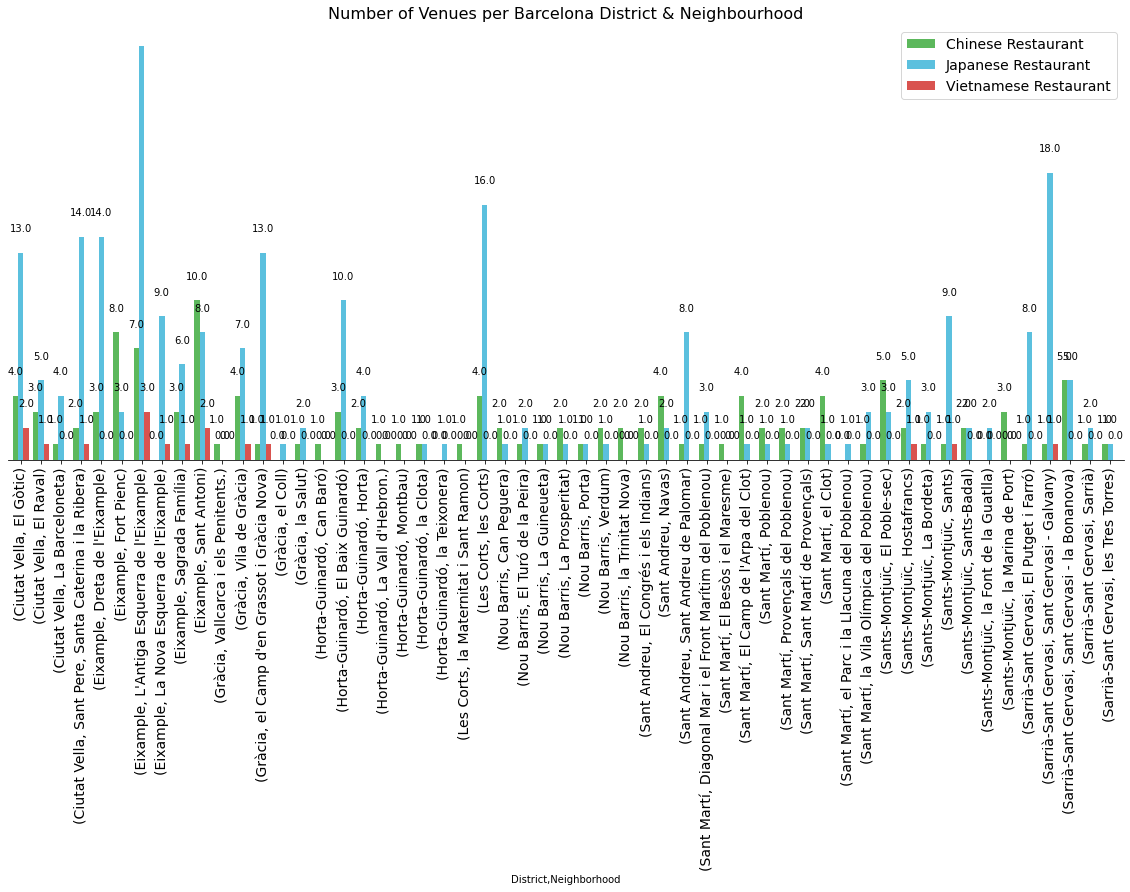

In [41]:
#import matplotlib
#import matplotlib.pyplot as plt

custom_colors = ['#5cb85c','#5bc0de','#d9534f']

ax = Barcelona_City_Stats_Selected_Categories_Pivoted.plot(kind='bar', stacked=False, figsize=(20, 8), color=custom_colors, fontsize=14, width = 0.8 )
ax.set_title('Number of Venues per Barcelona District & Neighbourhood', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.legend(fontsize=14)
plt.tick_params(left=False, labelleft=False)
   
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+.13, p.get_height() +1.5), va="center", ha="center")
#plt.show()

Now we have visualized the dataframe in a bar chart, we can see that our first impression is correct. There are lot of neighboorhoods with no Vietnamese restaurants at all. To my personal surprise there are a lot of Japanese restaurants and in most neighbourhoods you can find these type of restaurants more than Chinese and Vietnamese restaurants.
<br><br>
Now let's show the venues on the map to visualize where in Barcelona we can find these Japanese, Chinese and Vietnamese restaurants.


In [42]:
# add Venue markers to map
for lat, lng, venue, venuecategory in zip(barcelona_venues_sel_cat['Venue Latitude'], barcelona_venues_sel_cat['Venue Longitude'], barcelona_venues_sel_cat['Venue'], barcelona_venues_sel_cat['Venue Category']):
    label = '{}, {}'.format(venue, venuecategory)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_barcelona)  
    
    
# display map
map_barcelona

The visual shows as that most of the venues can be found in the neighbourhood of the city center of Barcelona.

<h3>3.4 Show Paris and the boroughs on the map. </h3>

Paris has in total 20 boroughs (called arrondissements in French) and 80 neighborhoods. To explore, analyze and segment neighborhoods, longitude and latitude of each neighbor and borough will be added.
This dataset exists for free on the web.

Links to the dataset are:
- https://www.data.gouv.fr/fr/datasets/r/e88c6fda-1d09-42a0-a069-606d3259114e
- https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=json&timezone=Europe/Berlin

In [43]:
!wget -q -O 'paris_data.json'  "https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=json&timezone=Europe/Berlin"
print('Data downloaded!')

Data downloaded!


Now the JSON-file with the data about Paris and it's arrondissementsand neighborhoods, let's put it into a pandas dataframe.

In [44]:
with open('paris_data.json') as paris_json_data:
    paris_data = json.load(paris_json_data)

##paris_data

In [45]:
# define the dataframe columns for the new dataframe
column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
paris_neighbourhoods = pd.DataFrame(columns=column_names)

for data in paris_data:
    borough = neighborhood_name = data['fields']['c_ar'] 
    neighborhood_name = data['fields']['l_qu']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    paris_neighbourhoods = paris_neighbourhoods.append({'Borough': borough,
                                          'Neighbourhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
paris_neighbourhoods.head(5)

Borough              Neighbourhood   Latitude  Longitude
0       4              Saint-Gervais  48.855719   2.358162
1       7       Saint-Thomas-d'Aquin  48.855263   2.325588
2      10          Porte-Saint-Denis  48.873618   2.352283
3       1  Saint-Germain-l'Auxerrois  48.860650   2.334910
4      19                   Villette  48.887661   2.374468

In [46]:
print('The Paris dataframe has {} boroughs and {} neighbourhoods.'.format(
        len(paris_neighbourhoods['Borough'].unique()),
        paris_neighbourhoods.shape[0]
    )
)

The Paris dataframe has 20 boroughs and 80 neighbourhoods.


In [47]:
par_address = 'Paris, FR'

par_geolocator = Nominatim(user_agent="par__explorer")
par_location = par_geolocator.geocode(par_address)
par_latitude = par_location.latitude
par_longitude = par_location.longitude
print('The geograpical coordinate of Paris (FR) are {}, {}.'.format(par_latitude, par_longitude))

The geograpical coordinate of Paris (FR) are 48.8566969, 2.3514616.


In [48]:
# create map of Paris using latitude and longitude values
map_paris = folium.Map(location=[par_latitude, par_longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighbourhood in zip(paris_neighbourhoods['Latitude'], paris_neighbourhoods['Longitude'], paris_neighbourhoods['Borough'], paris_neighbourhoods['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

<h3>3.5 Using Foursquare to discover Paris Venues. </h3>

<h4>3.5.1 Using Foursquare to discover Paris Venues from all kinds of categories</h4>

In [49]:
paris_venues = getNearbyVenues(names=paris_neighbourhoods['Neighbourhood'],
                                   latitudes=paris_neighbourhoods['Latitude'],
                                   longitudes=paris_neighbourhoods['Longitude']
                                  )

In [50]:
print(paris_venues.shape)
paris_venues.head(5)

(5248, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude                                 Venue  Venue Latitude  Venue Longitude      Venue Category
0  Saint-Gervais              48.855719                2.358162                                Miznon       48.857201         2.358957  Israeli Restaurant
1  Saint-Gervais              48.855719                2.358162                      Comme à Lisbonne       48.856767         2.356462                Café
2  Saint-Gervais              48.855719                2.358162               Aux Merveilleux de Fred       48.855686         2.356369        Dessert Shop
3  Saint-Gervais              48.855719                2.358162  Maison Européenne de la Photographie       48.855128         2.358948          Art Museum
4  Saint-Gervais              48.855719                2.358162                      L'As du Fallafel       48.857414         2.359078  Falafel Restaurant

In [51]:
#### Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories in Paris.'.format(len(paris_venues['Venue Category'].unique())))

There are 300 uniques categories in Paris.


In [52]:
#Analyze Each Neighborhood of Paris
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighborhood'] = paris_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

Neighborhood  Accessories Store  Afghan Restaurant  African Restaurant  Alsatian Restaurant  American Restaurant  Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  Athletics & Sports  Auvergne Restaurant  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  Basketball Court  Basque Restaurant  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Belgian Restaurant  Big Box Store  Bike Rental / Bike Share  Bistro  Boat or Ferry  Bookstore  Botanical Garden  Boutique  Boxing Gym  Brasserie  Brazilian Restaurant  Breakfast Spot  Breton Restaurant  Brewery  Bridge  Bubble Tea Shop  Building  Burger Joint  Burgundian Restaurant  Bus Line  Bus Station  Bus Stop  Butcher  Café  Cajun / Creole Restaurant  Cambodian Restaurant  Camera Store  Canal  Canal Lock  Candy Store  Cantonese Restaurant  Caribbean Restaurant  Caucasian Restaurant  Cemetery  Ch'ti Restaurant  Cheese Shop  Chinese Restaurant  Chocolate Shop  Church  Circus  Clothing Store  Cocktail Bar  Coffee Shop  College Theater  Comedy Club  Comfort Food Restaurant  Comic Shop  Concert Hall  Convenience Store  Corsican Restaurant  Cosmetics Shop  Costume Shop  Creperie  Cultural Center  Cupcake Shop  Cycle Studio  Dance Studio  Deli / Bodega  Department Store  Design Studio  Dessert Shop  Diner  Discount Store  Dive Bar  Dive Spot  Doner Restaurant  Donut Shop  Eastern European Restaurant  Electronics Store  Empanada Restaurant  English Restaurant  Escape Room  Ethiopian Restaurant  Exhibit  Falafel Restaurant  Farmers Market  Fast Food Restaurant  Fish & Chips Shop  Fish Market  Flea Market  Flower Shop  Fondue Restaurant  Food  Food & Drink Shop  Food Court  Food Truck  Fountain  French Restaurant  Fried Chicken Joint  Furniture / Home Store  Gaming Cafe  Garden  Gas Station  Gastropub  Gay Bar  General College & University  General Entertainment  Gift Shop  Gluten-free Restaurant  Gourmet Shop  Government Building  Greek Restaurant  Grocery Store  Gym  Gym / Fitness Center  Gym Pool  Hawaiian Restaurant  Health Food Store  Herbs & Spices Store  Historic Site  History Museum  Hobby Shop  Hookah Bar  Hostel  Hot Dog Joint  Hotel  Hotel Bar  Ice Cream Shop  Indian Restaurant  Indie Movie Theater  Indonesian Restaurant  Israeli Restaurant  Italian Restaurant  Japanese Restaurant  Jazz Club  Jewelry Store  Jewish Restaurant  Jiangxi Restaurant  Juice Bar  Karaoke Bar  Kebab Restaurant  Kids Store  Kitchen Supply Store  Korean Restaurant  Lake  Latin American Restaurant  Leather Goods Store  Lebanese Restaurant  Lingerie Store  Liquor Store  Locksmith  Lounge  Lyonese Bouchon  Mac & Cheese Joint  Market  Martial Arts School  Mediterranean Restaurant  Memorial Site  Men's Store  Metro Station  Mexican Restaurant  Middle Eastern Restaurant  Miscellaneous Shop  Mobile Phone Shop  Modern European Restaurant  Molecular Gastronomy Restaurant  Monument / Landmark  Moroccan Restaurant  Movie Theater  Multiplex  Museum  Music Store  Music Venue  New American Restaurant  Newsstand  Nightclub  Noodle House  Office  Okonomiyaki Restaurant  Opera House  Optical Shop  Organic Grocery  Outdoor Sculpture  Outdoors & Recreation  Paper / Office Supplies Store  Park  Pastry Shop  Pedestrian Plaza  Performing Arts Venue  Perfume Shop  Peruvian Restaurant  Pet Café  Pet Store  Pharmacy  Pier  Pizza Place  Planetarium  Platform  Playground  Plaza  Poke Place  Pool  Portuguese Restaurant  Provençal Restaurant  Pub  Racecourse  Ramen Restaurant  Record Shop  Recreation Center  Resort  Restaurant  Rock Club  Romanian Restaurant  Roof Deck  Russian Restaurant  Salad Place  Salon / Barbershop  Sandwich Place  Savoyard Restaurant  Scandinavian Restaurant  Scenic Lookout  Science Museum  Sculpture Garden  Seafood Restaurant  Shanxi Restaurant  Shoe Store  Shopping Mall  Shopping Plaza  Smoke Shop  Snack Place  Soccer Field  Soccer Stadium  Soup Place  South American Restaurant  Southern / Soul Food Restaurant  Southwestern 

In [53]:
# And let's examine the new dataframe size.
paris_onehot.shape

(5248, 301)

In [54]:
# Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()
paris_grouped

Neighborhood  Accessories Store  Afghan Restaurant  African Restaurant  Alsatian Restaurant  American Restaurant  Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  Athletics & Sports  Auvergne Restaurant  BBQ Joint  Baby Store  Bagel Shop    Bakery      Bank       Bar  Basketball Court  Basque Restaurant  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Belgian Restaurant  Big Box Store  Bike Rental / Bike Share    Bistro  Boat or Ferry  Bookstore  Botanical Garden  Boutique  Boxing Gym  Brasserie  Brazilian Restaurant  Breakfast Spot  Breton Restaurant   Brewery    Bridge  Bubble Tea Shop  Building  Burger Joint  Burgundian Restaurant  Bus Line  Bus Station  Bus Stop   Butcher      Café  Cajun / Creole Restaurant  Cambodian Restaurant  Camera Store     Canal  Canal Lock  Candy Store  Cantonese Restaurant  Caribbean Restaurant  Caucasian Restaurant  Cemetery  Ch'ti Restaurant  Cheese Shop  Chinese Restaurant  Chocolate Shop    Church  Circus  Clothing Store  Cocktail Bar  Coffee Shop  College Theater  Comedy Club  Comfort Food Restaurant  Comic Shop  Concert Hall  Convenience Store  Corsican Restaurant  Cosmetics Shop  Costume Shop  Creperie  Cultural Center  Cupcake Shop  Cycle Studio  Dance Studio  Deli / Bodega  Department Store  Design Studio  Dessert Shop     Diner  Discount Store  Dive Bar  Dive Spot  Doner Restaurant  Donut Shop  Eastern European Restaurant  Electronics Store  Empanada Restaurant  English Restaurant  Escape Room  Ethiopian Restaurant   Exhibit  Falafel Restaurant  Farmers Market  Fast Food Restaurant  Fish & Chips Shop  Fish Market  Flea Market  Flower Shop  Fondue Restaurant      Food  Food & Drink Shop  Food Court  Food Truck  Fountain  French Restaurant  Fried Chicken Joint  Furniture / Home Store  Gaming Cafe    Garden  Gas Station  Gastropub   Gay Bar  General College & University  General Entertainment  Gift Shop  Gluten-free Restaurant  Gourmet Shop  Government Building  Greek Restaurant  Grocery Store       Gym  Gym / Fitness Center  Gym Pool  Hawaiian Restaurant  Health Food Store  Herbs & Spices Store  Historic Site  History Museum  Hobby Shop  Hookah Bar    Hostel  Hot Dog Joint     Hotel  Hotel Bar  Ice Cream Shop  Indian Restaurant  Indie Movie Theater  Indonesian Restaurant  Israeli Restaurant  Italian Restaurant  Japanese Restaurant  Jazz Club  Jewelry Store  Jewish Restaurant  Jiangxi Restaurant  Juice Bar  Karaoke Bar  Kebab Restaurant  Kids Store  Kitchen Supply Store  Korean Restaurant   Lake  Latin American Restaurant  Leather Goods Store  Lebanese Restaurant  Lingerie Store  Liquor Store  Locksmith    Lounge  Lyonese Bouchon  Mac & Cheese Joint    Market  Martial Arts School  Mediterranean Restaurant  Memorial Site  Men's Store  Metro Station  Mexican Restaurant  Middle Eastern Restaurant  Miscellaneous Shop  Mobile Phone Shop  Modern European Restaurant  Molecular Gastronomy Restaurant  Monument / Landmark  Moroccan Restaurant  Movie Theater  Multiplex    Museum  Music Store  Music Venue  New American Restaurant  Newsstand  Nightclub  Noodle House    Office  Okonomiyaki Restaurant  Opera House  Optical Shop  Organic Grocery  Outdoor Sculpture  Outdoors & Recreation  Paper / Office Supplies Store      Park  Pastry Shop  Pedestrian Plaza  Performing Arts Venue  Perfume Shop  Peruvian Restaurant  Pet Café  Pet Store  Pharmacy      Pier  Pizza Place  Planetarium  Platform  Playground     Plaza  Poke Place      Pool  Portuguese Restaurant  Provençal Restaurant       Pub  Racecourse  Ramen Restaurant  Record Shop  Recreation Center    Resort  Restaurant  Rock Club  Romanian Restaurant  Roof Deck  Russian Restaurant  Salad Place  Salon / Barbershop  Sandwich Place  Savoyard Restaurant  Scandinavian Restaurant  Scenic Lookout  Science Museum  Sculpture Garden  Seafood Restaurant  Shanxi Restaurant  Shoe Store  Shopping Mall  Shopping Plaza  Smoke Shop  Snack Place  Soccer Field  Soccer Stadium  Soup Pl

In [55]:
# Let's check the new size
paris_grouped.shape

(80, 301)

In [56]:
num_top_venues = 5

for hood in paris_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = paris_grouped[paris_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Amérique----
               venue  freq
0  French Restaurant  0.17
1              Plaza  0.17
2        Supermarket  0.17
3            Theater  0.08
4             Bistro  0.08


----Archives----
               venue  freq
0  French Restaurant  0.07
1              Hotel  0.05
2     Clothing Store  0.05
3       Cocktail Bar  0.04
4        Coffee Shop  0.04


----Arsenal----
               venue  freq
0  French Restaurant  0.18
1              Hotel  0.08
2              Plaza  0.04
3   Tapas Restaurant  0.04
4               Park  0.04


----Arts-et-Métiers----
               venue  freq
0  French Restaurant  0.09
1              Hotel  0.06
2       Cocktail Bar  0.05
3                Bar  0.04
4         Restaurant  0.04


----Auteuil----
          venue  freq
0  Tennis Court  0.28
1       Stadium  0.17
2        Garden  0.11
3        Museum  0.06
4         Plaza  0.06


----Batignolles----
                venue  freq
0   French Restaurant  0.20
1               Hotel  0.12
2  Italian Resta

In [57]:
#Now let's create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
paris_neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
paris_neighbourhoods_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    paris_neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

paris_neighbourhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue
0         Amérique     French Restaurant                 Plaza           Supermarket                Bistro        Bed & Breakfast                  Park                  Café                Theater                  Pool      Fish & Chips Shop
1         Archives     French Restaurant                 Hotel        Clothing Store           Art Gallery           Cocktail Bar           Coffee Shop                   Bar                  Plaza                Bistro              Bookstore
2          Arsenal     French Restaurant                 Hotel                  Park                 Plaza       Tapas Restaurant    Italian Restaurant       Thai Restaurant           Cocktail Bar    Seafood Restaurant          Boat or Ferry
3  Arts-et-Métiers     French Restaurant                 Hotel          Cocktail Bar    Italian Restaurant             Restaurant                   Bar              Wine Bar  Vietnamese Restaurant   Moroccan Restaurant     Chinese Restaurant
4          Auteuil          Tennis Court               Stadium                Garden            Racecourse  Outdoors & Recreation                Museum      Botanical Garden      French Restaurant                Office    Sporting Goods Shop

<h4>3.5.2 Cluster the Paris Neighborhoods with K-means clustering. </h4>

In [58]:
# set number of clusters
kclusters = 10

paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)

# run k-means clustering
paris_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
paris_kmeans.labels_[0:10] 

array([3, 6, 4, 6, 8, 4, 5, 1, 7, 6], dtype=int32)

In [59]:
# Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
# add clustering labels
paris_neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', paris_kmeans.labels_)

paris_merged = paris_neighbourhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
paris_merged = pd.merge(paris_merged, paris_neighbourhoods_venues_sorted, how='inner', left_on='Neighbourhood', right_on='Neighborhood')
paris_merged = paris_merged.drop(columns=['Neighborhood'])
#barcelona_merged = barcelona_merged.join(bcn_neighbourhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

paris_merged.head() # check the last columns!

Borough              Neighbourhood   Latitude  Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue          6th Most Common Venue  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue 10th Most Common Venue
0       4              Saint-Gervais  48.855719   2.358162               6     French Restaurant        Clothing Store                 Hotel    Italian Restaurant        Ice Cream Shop                    Pastry Shop        Thai Restaurant               Gay Bar          Gourmet Shop       Tapas Restaurant
1       7       Saint-Thomas-d'Aquin  48.855263   2.325588               4     French Restaurant                 Hotel                  Café           Art Gallery           Coffee Shop             Italian Restaurant            Tailor Shop        Sandwich Place                Bakery            Cheese Shop
2      10          Porte-Saint-Denis  48.873618   2.352283               6                 Hotel     French Restaurant                Bakery                   Bar                Bistro  Vegetarian / Vegan Restaurant  Vietnamese Restaurant     Indian Restaurant   Japanese Restaurant            Pizza Place
3       1  Saint-Germain-l'Auxerrois  48.860650   2.334910               4     French Restaurant                 Hotel                 Plaza           Coffee Shop    Italian Restaurant                            Bar          Historic Site            Art Museum        Cosmetics Shop                   Café
4      19                   Villette  48.887661   2.374468               7                 Hotel                   Bar     French Restaurant                  Café      Asian Restaurant                     Food Truck              Multiplex  Fast Food Restaurant           Supermarket                 Bistro

In [60]:
# create map
map_paris_clusters = folium.Map(location=[par_latitude, par_longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Neighbourhood'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_paris_clusters)
       
map_paris_clusters

<h4>3.5.3 Examing the Paris Clusters </h4>

In [61]:
paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue 6th Most Common Venue 7th Most Common Venue 8th Most Common Venue 9th Most Common Venue 10th Most Common Venue
66  Ecole-Militaire                 Hotel     French Restaurant                 Plaza                Garden                 Diner           Pastry Shop                  Café        Farmers Market                Bistro       Asian Restaurant

In [62]:
paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue      6th Most Common Venue 7th Most Common Venue 8th Most Common Venue 9th Most Common Venue 10th Most Common Venue
6            Notre-Dame     French Restaurant   Japanese Restaurant                  Café                Bakery                 Plaza                Coffee Shop    Italian Restaurant              Wine Bar        Ice Cream Shop              Bookstore
8          Saint-Victor     French Restaurant                 Hotel                Bakery    Italian Restaurant                   Bar                     Bistro                 Plaza                Museum                  Park    Japanese Restaurant
12    Grandes-Carrières     French Restaurant                   Bar                 Hotel       Thai Restaurant            Restaurant                       Park           Pizza Place                Bistro    Italian Restaurant       Arepa Restaurant
18    Sainte-Marguerite     French Restaurant                   Bar    Italian Restaurant                 Hotel                Bistro                 Beer Store                Bakery           Pastry Shop       Thai Restaurant               Beer Bar
23               Halles     French Restaurant                Bakery                   Bar    Italian Restaurant    Chinese Restaurant                      Plaza        Clothing Store                   Pub            Restaurant         Sandwich Place
32            Epinettes     French Restaurant   Japanese Restaurant                Bakery            Restaurant  Ethiopian Restaurant       Gym / Fitness Center                Garden      Sushi Restaurant    Turkish Restaurant           Burger Joint
37         Clignancourt     French Restaurant                   Bar                  Café    Italian Restaurant               Theater                  Gastropub           Pizza Place     Convenience Store            Restaurant                 Bistro
43       Saint-Ambroise     French Restaurant                   Bar            Restaurant                Bakery                Bistro         Italian Restaurant                 Hotel   Japanese Restaurant             Juice Bar     Mexican Restaurant
53  Hôpital-Saint-Louis     French Restaurant                   Bar           Coffee Shop              Wine Bar                  Café           Asian Restaurant           Pizza Place                Bistro                Garden                  Diner
54           Belleville                   Bar     French Restaurant   Japanese Restaurant    Italian Restaurant                  Café                     Bistro          Burger Joint               Theater       Thai Restaurant     Chinese Restaurant
72       Maison-Blanche     French Restaurant                Bakery                 Plaza  Fast Food Restaurant                  Café                     Bistro           Pizza Place                  Park              Bus Stop                Stadium
73          Croulebarbe     French Restaurant      Sushi Restaurant                   Bar    Italian Restaurant                Bakery                       Park        Sandwich Place                 Hotel          Burger Joint            Gaming Cafe
74      Folie-Méricourt     French Restaurant                   Bar            Restaurant                Bakery              Wine Bar                     Bistro                 Hotel                   Gym          Burger Joint              Juice Bar
77               Combat     French Restaurant    Italian Restaurant                  Pool            Restaurant                  Park  Latin American Restaurant           Coffee Shop        Chocolate Shop        Scenic Lookout                   Café
79                Javel     French Restaurant                Bakery                  Café      Sushi Restaurant           Pizza Place        Japanese Restaurant   Lebanese Restaurant         Metro Station   Moroccan Restaurant   Fast Food Restaurant

In [63]:
paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue        3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue 6th Most Common Venue 7th Most Common Venue 8th Most Common Venue 9th Most Common Venue 10th Most Common Venue
60        Picpus             Locksmith    Falafel Restaurant  Eastern European Restaurant     Electronics Store   Empanada Restaurant    English Restaurant           Escape Room  Ethiopian Restaurant               Exhibit            Zoo Exhibit

In [64]:
paris_merged.loc[paris_merged['Cluster Labels'] == 3, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue     6th Most Common Venue 7th Most Common Venue 8th Most Common Venue 9th Most Common Venue 10th Most Common Venue
10  Saint-Fargeau           Supermarket  Arts & Entertainment                  Pool                 Plaza                  Café                Food Truck           Pizza Place     French Restaurant                 Diner           Tram Station
50       Amérique     French Restaurant                 Plaza           Supermarket                Bistro       Bed & Breakfast                      Park                  Café               Theater                  Pool      Fish & Chips Shop
65    La Chapelle          Soccer Field    Chinese Restaurant           Supermarket    Mexican Restaurant                 Diner                  Gym Pool                Garden      Asian Restaurant       Thai Restaurant      French Restaurant
78       Charonne           Supermarket                 Hotel                   Bar     French Restaurant          Tram Station  Bike Rental / Bike Share           Coffee Shop  Brazilian Restaurant        Soccer Stadium           Soccer Field

In [65]:
paris_merged.loc[paris_merged['Cluster Labels'] == 4, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue          4th Most Common Venue  5th Most Common Venue  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue           9th Most Common Venue         10th Most Common Venue
1        Saint-Thomas-d'Aquin     French Restaurant                 Hotel                  Café                    Art Gallery            Coffee Shop     Italian Restaurant           Tailor Shop        Sandwich Place                          Bakery                    Cheese Shop
3   Saint-Germain-l'Auxerrois     French Restaurant                 Hotel                 Plaza                    Coffee Shop     Italian Restaurant                    Bar         Historic Site            Art Museum                  Cosmetics Shop                           Café
7                Gros-Caillou     French Restaurant    Italian Restaurant                 Hotel                           Café            Coffee Shop         Ice Cream Shop                Bakery                Bistro                    Dessert Shop                   Burger Joint
9                   Madeleine                 Hotel     French Restaurant              Boutique                  Women's Store           Gourmet Shop         Clothing Store          Dessert Shop        Sandwich Place                         Theater                    Men's Store
14              Saint-Georges                 Hotel     French Restaurant          Cocktail Bar             Italian Restaurant       Sushi Restaurant  Vietnamese Restaurant                Bistro                  Café                          Lounge             Falafel Restaurant
15           Chaussée-d'Antin     French Restaurant                 Hotel           Salad Place                 Clothing Store       Department Store            Coffee Shop                Bistro               Theater            Gym / Fitness Center                   Concert Hall
17                     Europe     French Restaurant                 Hotel            Restaurant                    Pizza Place              Wine Shop         Sandwich Place       Thai Restaurant                   Bar                          Bistro                            Pub
20              Saint-Lambert     French Restaurant                 Hotel    Italian Restaurant                           Café        Thai Restaurant                 Bakery      Sushi Restaurant           Supermarket                       Bookstore                     Sports Bar
21               Rochechouart     French Restaurant                 Hotel                Bakery  Vegetarian / Vegan Restaurant            Pizza Place                   Park            Restaurant                   Bar              Italian Restaurant                    Coffee Shop
26          Faubourg-du-Roule                 Hotel     French Restaurant         Jewelry Store                 Clothing Store     Italian Restaurant       Asian Restaurant   Japanese Restaurant           Men's Store               Electronics Store               Department Store
27      Notre-Dame-des-Champs     French Restaurant                 Hotel                Bakery            Japanese Restaurant     Italian Restaurant                 Bistro            Steakhouse              Creperie                             Pub                     Bagel Shop
28            Petit-Montrouge                 Hotel     French Restaurant    Italian Restaurant                    Supermarket                  Plaza    Japanese Restaurant     Food & Drink Shop        Sandwich Place                Sushi Restaurant                         Bakery
31                   Chaillot                 Hotel     French Restaurant    Italian Restaurant                         Bakery                  Plaza             Art Museum    Chinese Restaurant                   Pub                            Café            Japanese Restaurant
41     Saint-Germain-des-Prés     French Restaurant                 Hotel    Italian Restaurant 

In [66]:
paris_merged.loc[paris_merged['Cluster Labels'] == 5, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue 6th Most Common Venue 7th Most Common Venue 8th Most Common Venue 9th Most Common Venue 10th Most Common Venue
44       Bel-Air           Sports Club     Recreation Center                  Café                 Plaza            Playground     French Restaurant           Zoo Exhibit               Exhibit   Empanada Restaurant     English Restaurant

In [67]:
paris_merged.loc[paris_merged['Cluster Labels'] == 6, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue          5th Most Common Venue          6th Most Common Venue   7th Most Common Venue  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue
0         Saint-Gervais     French Restaurant        Clothing Store                 Hotel    Italian Restaurant                 Ice Cream Shop                    Pastry Shop         Thai Restaurant                Gay Bar          Gourmet Shop       Tapas Restaurant
2     Porte-Saint-Denis                 Hotel     French Restaurant                Bakery                   Bar                         Bistro  Vegetarian / Vegan Restaurant   Vietnamese Restaurant      Indian Restaurant   Japanese Restaurant            Pizza Place
5           Saint-Merri     French Restaurant        Ice Cream Shop           Art Gallery        Clothing Store                          Plaza                           Café            Cocktail Bar            Coffee Shop                   Bar                 Bakery
13             Sorbonne                 Hotel     French Restaurant   Indie Movie Theater                 Plaza                      Bookstore                    Coffee Shop                    Café         Ice Cream Shop    Italian Restaurant            Pizza Place
24      Arts-et-Métiers     French Restaurant                 Hotel          Cocktail Bar    Italian Restaurant                     Restaurant                            Bar                Wine Bar  Vietnamese Restaurant   Moroccan Restaurant     Chinese Restaurant
25             Archives     French Restaurant                 Hotel        Clothing Store           Art Gallery                   Cocktail Bar                    Coffee Shop                     Bar                  Plaza                Bistro              Bookstore
33        Quinze-Vingts     French Restaurant           Coffee Shop        Sandwich Place                 Hotel                         Bakery             Italian Restaurant          Farmers Market          Train Station          Cocktail Bar                    Bar
34                 Mail          Cocktail Bar     French Restaurant              Wine Bar    Italian Restaurant                            Bar                         Bakery             Salad Place            Coffee Shop       Thai Restaurant                  Hotel
35       Bonne-Nouvelle     French Restaurant          Cocktail Bar              Wine Bar    Italian Restaurant                          Hotel                            Bar             Coffee Shop                 Bakery            Restaurant     Chinese Restaurant
39             Vivienne   Japanese Restaurant     French Restaurant                Bistro              Wine Bar                      Bookstore              Korean Restaurant  Furniture / Home Store                 Bakery    Italian Restaurant       Ramen Restaurant
40       Enfants-Rouges     French Restaurant                 Hotel                Bistro              Wine Bar             Italian Restaurant                            Bar     Japanese Restaurant            Coffee Shop          Cocktail Bar             Restaurant
48  Faubourg-Montmartre     French Restaurant                 Hotel           Pizza Place    Italian Restaurant  Vegetarian / Vegan Restaurant                   Cocktail Bar         Thai Restaurant                 Bakery    Chinese Restaurant    Japanese Restaurant
52         Sainte-Avoie     French Restaurant           Art Gallery    Chinese Restaurant                Bakery                     Restaurant                          Hotel                    Café            Coffee Shop    Italian Restaurant           Burger Joint
58   Porte-Saint-Martin           Coffee Shop     French Restaurant      Asian Restaurant               Theater                         Bakery                            Bar                    Café           Cocktail Bar                 Hotel            Pizza Place
59             Roque

In [68]:
paris_merged.loc[paris_merged['Cluster Labels'] == 7, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue     6th Most Common Venue  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue    10th Most Common Venue
4             Villette                 Hotel                   Bar     French Restaurant                  Café      Asian Restaurant                Food Truck              Multiplex  Fast Food Restaurant           Supermarket                    Bistro
11      Porte-Dauphine          Tennis Court     French Restaurant         Grocery Store                  Park                 Plaza                      Café            Pizza Place           Supermarket              Pharmacy                  Gym Pool
16        Palais-Royal   Japanese Restaurant                 Hotel    Italian Restaurant     French Restaurant      Ramen Restaurant                     Plaza            Coffee Shop                  Café     Korean Restaurant                       Bar
19  Parc-de-Montsouris    Italian Restaurant   Japanese Restaurant      Kebab Restaurant                  Park               Theater  Bike Rental / Bike Share                 Bistro                   Gym   Lebanese Restaurant        Chinese Restaurant
22               Bercy                 Hotel    Italian Restaurant              Bus Stop                Bakery  Gym / Fitness Center         French Restaurant               Wine Bar                 Plaza                Museum               Supermarket
29     Pont-de-Flandre                  Café         Boat or Ferry   Japanese Restaurant             Rock Club            Restaurant                     Hotel          Movie Theater     French Restaurant      Asian Restaurant              Tram Station
36                Gare                 Hotel       Thai Restaurant   Japanese Restaurant     French Restaurant        Sandwich Place     Vietnamese Restaurant                   Café           Coffee Shop    Italian Restaurant                     Plaza
38         Goutte-d'Or                   Bar  Fast Food Restaurant           Supermarket    Chinese Restaurant                Bakery          Asian Restaurant  Vietnamese Restaurant               Theater                  Pool  Mediterranean Restaurant
49             Gaillon   Japanese Restaurant                 Hotel     French Restaurant           Pastry Shop                Bakery                  Wine Bar      Korean Restaurant      Asian Restaurant          Concert Hall               Coffee Shop
64       Père-Lachaise                   Bar                Bistro                Bakery   Japanese Restaurant                  Park         French Restaurant     Italian Restaurant                 Plaza              Wine Bar                  Bus Line

In [69]:
paris_merged.loc[paris_merged['Cluster Labels'] == 8, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue 8th Most Common Venue 9th Most Common Venue 10th Most Common Venue
68       Auteuil          Tennis Court               Stadium                Garden            Racecourse  Outdoors & Recreation                Museum      Botanical Garden     French Restaurant                Office    Sporting Goods Shop

In [70]:
paris_merged.loc[paris_merged['Cluster Labels'] == 9, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

Neighbourhood 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue 6th Most Common Venue 7th Most Common Venue 8th Most Common Venue 9th Most Common Venue 10th Most Common Venue
30        Muette     French Restaurant                  Lake           Snack Place                  Pool  Gym / Fitness Center         Boat or Ferry                 Diner           Zoo Exhibit   Empanada Restaurant     English Restaurant

<h3>3.6 Using Foursquare to discover Paris Venues by having a look at the selected categories. </h3>

In [71]:
paris_venues_sel_cat = getNearbyVenuesCat(names=paris_neighbourhoods['Neighbourhood'],
                                   latitudes=paris_neighbourhoods['Latitude'],
                                   longitudes=paris_neighbourhoods['Longitude']
                                  )

In [72]:
print(paris_venues_sel_cat.shape)

#barcelona_venues_sel_cat.groupby('Neighborhood').count()

paris_venues_sel_cat_ext = pd.merge(paris_venues_sel_cat, venue_categories, how='left', left_on='Venue Category', right_on='CategoryName_l3')

paris_venues_sel_cat_ext = paris_venues_sel_cat_ext.drop(columns=['MainCategoryName', 'CategoryName_L1', 'CategoryName_l3', 'CategoryName_l4'])

paris_venues_sel_cat_ext.CategoryName_l2.fillna(paris_venues_sel_cat_ext['Venue Category'], inplace=True)

paris_venues_sel_cat_ext = paris_venues_sel_cat_ext.rename(columns={'CategoryName_l2': 'Venue Final Category'})

print(paris_venues_sel_cat_ext.head())
print(paris_venues_sel_cat_ext.shape)

(1519, 7)
    Neighborhood  Neighborhood Latitude  Neighborhood Longitude           Venue  Venue Latitude  Venue Longitude         Venue Category   Venue Final Category
0  Saint-Gervais              48.855719                2.358162          Kiccho       48.857261         2.354938    Japanese Restaurant    Japanese Restaurant
1  Saint-Gervais              48.855719                2.358162          Sancho       48.855803         2.356545    Japanese Restaurant    Japanese Restaurant
2  Saint-Gervais              48.855719                2.358162  Shinjuku Sushi       48.853990         2.362225    Japanese Restaurant    Japanese Restaurant
3  Saint-Gervais              48.855719                2.358162      Allo Sushi       48.856317         2.357121       Sushi Restaurant    Japanese Restaurant
4  Saint-Gervais              48.855719                2.358162       Minh Chau       48.857163         2.355156  Vietnamese Restaurant  Vietnamese Restaurant
(1519, 8)


In [73]:
#Filter out records not in the category list.
paris_venues_sel_cat_ext = paris_venues_sel_cat_ext[paris_venues_sel_cat_ext['Venue Final Category'].isin(category_list)]
print(paris_venues_sel_cat_ext.shape)

(1499, 8)


In [74]:
# Number of restaurants per Neighbourhood and Venue Final Category
Paris_City_Stats_Selected_Categories = paris_venues_sel_cat_ext.groupby( ['Neighborhood', 'Venue Final Category'] ).size().to_frame(name = 'count').reset_index()
Paris_City_Stats_Selected_Categories = pd.merge(Paris_City_Stats_Selected_Categories, paris_neighbourhoods, how='left', left_on='Neighborhood', right_on='Neighbourhood')
Paris_City_Stats_Selected_Categories

Neighborhood   Venue Final Category  count Borough              Neighbourhood   Latitude  Longitude
0                     Amérique     Chinese Restaurant      1      19                   Amérique  48.881638   2.395440
1                     Amérique  Vietnamese Restaurant      1      19                   Amérique  48.881638   2.395440
2                     Archives     Chinese Restaurant      3       3                   Archives  48.859192   2.363205
3                     Archives    Japanese Restaurant     14       3                   Archives  48.859192   2.363205
4                      Arsenal     Chinese Restaurant      5       4                    Arsenal  48.851585   2.364768
5                      Arsenal    Japanese Restaurant      7       4                    Arsenal  48.851585   2.364768
6              Arts-et-Métiers     Chinese Restaurant     17       3            Arts-et-Métiers  48.866470   2.357083
7              Arts-et-Métiers    Japanese Restaurant     13       3            Arts-et-Métiers  48.866470   2.357083
8              Arts-et-Métiers  Vietnamese Restaurant     10       3            Arts-et-Métiers  48.866470   2.357083
9                  Batignolles     Chinese Restaurant      3      17                Batignolles  48.888482   2.313856
10                 Batignolles    Japanese Restaurant     15      17                Batignolles  48.888482   2.313856
11                 Batignolles  Vietnamese Restaurant      1      17                Batignolles  48.888482   2.313856
12                  Belleville     Chinese Restaurant      2      20                 Belleville  48.871531   2.387549
13                  Belleville    Japanese Restaurant      4      20                 Belleville  48.871531   2.387549
14                  Belleville  Vietnamese Restaurant      2      20                 Belleville  48.871531   2.387549
15                       Bercy     Chinese Restaurant      1      12                      Bercy  48.835209   2.386210
16                       Bercy    Japanese Restaurant      8      12                      Bercy  48.835209   2.386210
17                       Bercy  Vietnamese Restaurant      3      12                      Bercy  48.835209   2.386210
18              Bonne-Nouvelle     Chinese Restaurant     15       2             Bonne-Nouvelle  48.867150   2.350080
19              Bonne-Nouvelle    Japanese Restaurant     23       2             Bonne-Nouvelle  48.867150   2.350080
20              Bonne-Nouvelle  Vietnamese Restaurant      8       2             Bonne-Nouvelle  48.867150   2.350080
21                    Chaillot     Chinese Restaurant      7      16                   Chaillot  48.868434   2.291679
22                    Chaillot    Japanese Restaurant     11      16                   Chaillot  48.868434   2.291679
23                    Chaillot  Vietnamese Restaurant      2      16                   Chaillot  48.868434   2.291679
24              Champs-Elysées     Chinese Restaurant      7       8             Champs-Elysées  48.867074   2.308652
25              Champs-Elysées    Japanese Restaurant     12       8             Champs-Elysées  48.867074   2.308652
26              Champs-Elysées  Vietnamese Restaurant      2       8             Champs-Elysées  48.867074   2.308652
27                    Charonne     Chinese Restaurant      1      20                   Charonne  48.854760   2.407430
28                    Charonne    Japanese Restaurant      2      20                   Charonne  48.854760   2.407430
29            Chaussée-d'Antin     Chinese Restaurant     18       9           Chaussée-d'Antin  48.873547   2.332269
30            Chaussée-d'Antin    Japanese Restaurant     33       9           Chaussée-d'Antin  48.873547   2.332269
31            Chaussée-d'Antin  Vietnamese Restaurant      9       9           Chaussée-d'Antin  48.873547   2.332269
32                Clignancourt    Japanese Restaurant      7      18               Clignancourt  48.891668   2.345979
33    

Now we have all Paris venues of the selected restaurant categories, together with details about the neighbourhood, we need to pivot the dataframe so we can see for every neighbourhood the number of venues.

In [75]:
#df.pivot(index='foo', columns='bar', values='baz')
Paris_City_Stats_Selected_Categories_Pivoted = pd.pivot_table(Paris_City_Stats_Selected_Categories, index=['Borough','Neighborhood'], columns='Venue Final Category', values='count')
Paris_City_Stats_Selected_Categories_Pivoted

Venue Final Category               Chinese Restaurant  Japanese Restaurant  Vietnamese Restaurant
Borough Neighborhood                                                                             
1       Halles                                   15.0                 21.0                    3.0
        Palais-Royal                             10.0                 57.0                    6.0
        Place-Vendôme                             5.0                 29.0                    3.0
        Saint-Germain-l'Auxerrois                 2.0                  9.0                    NaN
2       Bonne-Nouvelle                           15.0                 23.0                    8.0
        Gaillon                                  11.0                 64.0                   11.0
        Mail                                     11.0                 21.0                    7.0
        Vivienne                                 16.0                 60.0                   11.0
3       Archives                                  3.0                 14.0                    NaN
        Arts-et-Métiers                          17.0                 13.0                   10.0
        Enfants-Rouges                            8.0                 16.0                    7.0
        Sainte-Avoie                             23.0                 20.0                    7.0
4       Arsenal                                   5.0                  7.0                    NaN
        Notre-Dame                                1.0                 14.0                    3.0
        Saint-Gervais                             4.0                 16.0                    3.0
        Saint-Merri                              12.0                 25.0                    6.0
5       Jardin-des-Plantes                        1.0                  5.0                    1.0
        Saint-Victor                              5.0                  7.0                    5.0
        Sorbonne                                 11.0                 20.0                    9.0
        Val-de-Grâce                              5.0                 13.0                    2.0
6       Monnaie                                   5.0                 18.0                    3.0
        Notre-Dame-des-Champs                     8.0                 12.0                    NaN
        Odéon                                     3.0                 11.0                    2.0
        Saint-Germain-des-Prés                    4.0                 16.0                    2.0
7       Ecole-Militaire                           NaN                  1.0                    NaN
        Gros-Caillou                              3.0                  8.0                    2.0
        Invalides                                 1.0                  2.0                    NaN
        Saint-Thomas-d'Aquin                      NaN                  4.0                    1.0
8       Champs-Elysées                            7.0                 12.0                    2.0
        Europe                                    2.0                 12.0                    2.0
        Faubourg-du-Roule                        10.0                 11.0                    1.0
        Madeleine                                 7.0                 14.0                    1.0
9       Chaussée-d'Antin                         18.0                 33.0                    9.0
        Faubourg-Montmartre                      23.0                 33.0                    1.0
        Rochechouart                              6.0                 16.0                    3.0
        Saint-Georges                             3.0                 22.0                    2.0
10      Hôpital-Saint-Louis                       1.0                  3.0                    1.0
        Porte-Saint-Denis                        10.0                 18.0                    3.0
        Porte-Saint-Martin                        9.0                 10.0      

At first glance the pivoted dataframe compared to the pivoted dataframe for Barcelona, that in Paris a lot more Vietnamese restaurants can be found. There are less 'NaN'-values int he respective column when compared to the Barcelona dataframe.

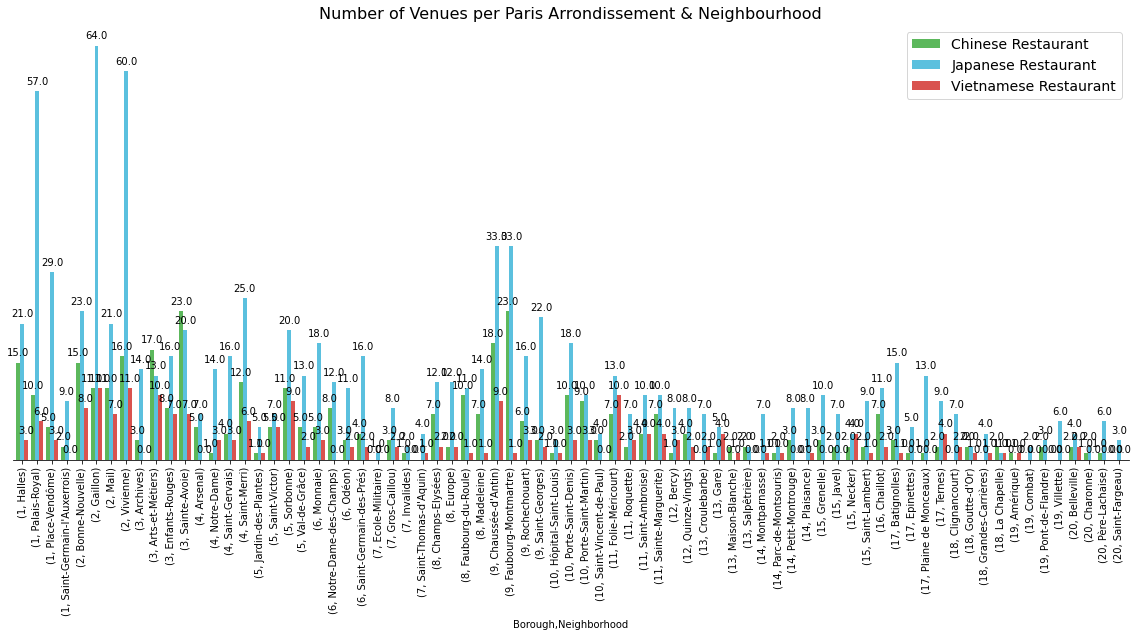

In [76]:
#import matplotlib
#import matplotlib.pyplot as plt

custom_colors = ['#5cb85c','#5bc0de','#d9534f']

ax = Paris_City_Stats_Selected_Categories_Pivoted.plot(kind='bar', stacked=False, figsize=(20, 8), color=custom_colors, fontsize=10, width = 0.8 )
ax.set_title('Number of Venues per Paris Arrondissement & Neighbourhood', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.legend(fontsize=14)
plt.tick_params(left=False, labelleft=False)
   
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+.13, p.get_height() +1.5), va="center", ha="center")
#plt.show()

Now we have visualized the dataframe in a bar chart, we can see that our first impression is correct. There are lot more neighboorhoods with a Vietnamese restaurants. Again to my personal surprise there are a lot of Japanese restaurants and in most neighbourhoods you can find these type of restaurants more than Chinese and Vietnamese restaurants.
<br><br>
Now let's show the venues on the map to visualize where in Paris we can find these Japanese, Chinese and Vietnamese restaurants.

In [77]:
paris_venues_sel_cat_ext['Venue Category'].unique()

array(['Japanese Restaurant', 'Sushi Restaurant', 'Vietnamese Restaurant',
       'Chinese Restaurant', 'Dim Sum Restaurant', 'Szechuan Restaurant',
       'Ramen Restaurant', 'Udon Restaurant', 'Cantonese Restaurant',
       'Taiwanese Restaurant', 'Soba Restaurant', 'Jiangxi Restaurant',
       'Okonomiyaki Restaurant', 'Shanxi Restaurant',
       'Shandong Restaurant'], dtype=object)

In [78]:
# add Venue markers to map
for lat, lng, venue, venuecategory in zip(paris_venues_sel_cat_ext['Venue Latitude'], paris_venues_sel_cat['Venue Longitude'], paris_venues_sel_cat['Venue'], paris_venues_sel_cat['Venue Category']):
    label = '{}, {}'.format(venue, venuecategory)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
    
# display map
map_paris

The visual shows us that most of the venues can be found in the first three arrondissements of Paris.

<h3>4. Results and discussion</h3>

Our analysis on the overall venues show that Paris has a lot more venues when compared to Barcelona. In Paris there are more than 5000 venues, 5248 to be exact, whereas Barcelona has almost 3000 venues, 2936 to be exact. When comparing the number of neighbourhoods there's little difference between the two cities. Paris has 80 neighbourhoods, whereas Barcelona has 75. Paris though, has twice the number of boroughs when comparing both cities. Paris has twenty (20) boroughs, called arrondissements in French, and Barcelona has ten (10) boroughs, called districsts.
<br><br>
When examining the clusters for Barcelona, we can see that cluster 6 is the biggest cluster and that most of the neighbourhoods can be found in the center of Barcelona. The second biggest cluster seems to be cluster 2 and most of it's neighbourhoods can be found outside of the city center of Barcelona.
When examining the clusters for Paris, we can see there are three big clusters. These are cluster 4, 6 and 1 are the biggest clusters. Cluster 4 has 28 neighbourhoods is most of them are located on the western side of Paris. Cluster 6 has 18 neighbourhoods and most of them are located on the eastern-center side of Paris. Cluster 1 has 15 neighbourhoods and these are more spread over Paris.
<br><br>
In our analysis among the venues of Paris and Barcelona, a closer look has been done for the Chinese, Japanese and Vietnamese restaurants. In Paris a number of 193 of these restaurants can be found, whereas in Barcelona there can be found only 108.<br>
When looking at the generated bar charts we can see that for Paris in most neighbourhoods restaurants can be found of each category. For Barcelona this is not the case. From the Barcelona bar chart we can also see that even for a lot of districts no Vietnamese restaurants can be found as well. 
For both cities we can see that there are a lot of Japanese restaurants and this category can be found the most in some neighbourhoods as well, as the Japanese restaurants has the most peaks in both bar charts.


<h3>5. Conclusion</h3>

Having a look at the clusters for both cities we can see the biggest clusters can be found in the centers of both cities. Barcelona has one big cluster and Paris has two big clusters which together also can be found in the center of the city.<br>
When having a look at the selected categories, we can see that Paris is better represented than Barcelona. Almost every neighbourhood has all three restaurant categories and Japanese restaurants are well represented in both cities.<br>
So are both cities similar or dissimilar? When looking at the cluster examination both cities are quite similar as on the map the biggest clusters are located in the city centers. However when looking at the selected categories, Paris is definitely the better choice as all three restaurant categories are better represented.<br>
So the final conclusion is that **Paris** should be the next destination!